# Построение и оптимизация моделей предсказания бинарных меток на датасете `Tox21`

## Для начала, нам необходимо предобработать данные для подачи их моделям классификации

Предобработка будет проводиться следующим образом:
1. Считываем данные из файла и удалим те, которые имею некорректную молекулярную структуру
2. Далее преобразуем метки SMILES *(Simplified Molecular Input Line Entry System)* в числовые признаки
3. Проверим корректность преобразования

После всех этих действий, мы сможем перейти к выбору оптимальной модели

In [34]:
import numpy as np
import pandas as pd
from rdkit import Chem

In [83]:
df = pd.read_csv('tox21.csv')
df

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
7827,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
7828,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
7829,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


In [84]:
print(df.shape)

(7831, 14)


Нам необходимо преобразовать информацию о молекулах, приведённую в формате SMILES, в вид, подходящий для обучения модели

Для начала убедимся, что все приведённые данные корректны и удалим те, что нам не подходят

In [85]:
def validate_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False


# Применение проверки
df['valid_smiles'] = df['smiles'].apply(validate_smiles)

# Удаление некорректных SMILES
df = df[df['valid_smiles']]
df.drop(columns=['valid_smiles'], inplace=True)


[21:18:07] WARNING: not removing hydrogen atom without neighbors


In [86]:
df.shape

(7831, 14)

Как видно, таких данных нет, что хорошо

Теперь преобразуем SMILES

In [87]:
from rdkit.Chem import rdFingerprintGenerator

# Создание экземпляра MorganGenerator
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=4, fpSize=2048)


# Функция для генерации дескрипторов
def generate_morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(morgan_gen.GetFingerprint(mol))  # Генерация вектора как списка
    return None


# Применение функции к DataFrame
df['morgan_fp'] = df['smiles'].apply(generate_morgan_fp)


[21:18:11] WARNING: not removing hydrogen atom without neighbors


In [88]:
# Убираем строки, где дескрипторы не удалось создать
df = df[df['morgan_fp'].notna()]

In [89]:
df.shape

(7831, 15)

## Выбор наиболее перспективной модели для обучения

Теперь, когда мы получили датасет, можно приступить к выбору модели.

Выбирать мы будем из следующего списка моделей:
* XGBoost
* LightGBM
* CatBoost
* RandomForest
* LogisticRegression


Обучим каждую из этих моделей со схожими параметрами и сравним их метрики

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    average_precision_score,
)
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

roc_auc = []
pr_auc = []
f1 = []

# Список моделей
models = {
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, tree_method='hist',
                             device='cuda'),
    "LightGBM": lgb.LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, verbose=0, random_state=42,
                                   task_type='GPU'),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
}

# Перебор моделей
tmp_rog_auc = []
tmp_pr_auc = []
tmp_f1 = []
for name, model in models.items():
    for i in df.columns[:-3]:
        df_cleaned = df.dropna(subset=[i, "morgan_fp"])

        X = np.array(df_cleaned["morgan_fp"].values.tolist())
        y = df_cleaned[i].astype(int).values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Обучение модели
        model.fit(X_train, y_train)

        # Предсказание
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(
            X_test)

        # Метрики
        tmp_rog_auc.append(roc_auc_score(y_test, y_proba))
        tmp_pr_auc.append(average_precision_score(y_test, y_proba))
        tmp_f1.append(f1_score(y_test, y_pred))
    roc_auc.append(sum(tmp_rog_auc) / len(tmp_rog_auc))
    pr_auc.append(sum(tmp_pr_auc) / len(tmp_pr_auc))
    f1.append(sum(tmp_f1) / len(tmp_f1))

Теперь, когда от моделей получены необходимые метрики, выберем наиболее подходящую нам модель.

Для это зададим веса для каждой из них, основываясь на условии задания, а далее выберем модель, дающую наибольший результат

In [43]:
weights = {
    "ROC-AUC": 0.2,  # Общая способность различать классы
    "PR-AUC": 0.5,  # Важность работы с положительным классом
    "F1-Score": 0.3,  # Баланс Precision и Recall
}
results = {
    "Model": ["XGBoost", "LightGBM", "CatBoost", "RandomForest", "LogisticRegression"],
    "ROC-AUC": roc_auc,
    "PR-AUC": pr_auc,
    "F1-Score": f1,
}
res = pd.DataFrame(results)

# Расчёт агрегированного показателя
res["Aggregate Score"] = (
        res["ROC-AUC"] * weights["ROC-AUC"] +
        res["PR-AUC"] * weights["PR-AUC"] +
        res["F1-Score"] * weights["F1-Score"]
)

# Выбор лучшей модели
best_model = res.loc[res["Aggregate Score"].idxmax()]
print(f"Лучшая модель: {best_model['Model']}")
print(res)

Лучшая модель: XGBoost
                Model   ROC-AUC    PR-AUC  F1-Score  Aggregate Score
0             XGBoost  0.790972  0.420194  0.353408         0.474314
1            LightGBM  0.781740  0.418226  0.356037         0.472272
2            CatBoost  0.780961  0.415117  0.339878         0.465714
3        RandomForest  0.787817  0.417628  0.320894         0.462646
4  LogisticRegression  0.783370  0.411616  0.334130         0.462721


По итогам, была выбрана модель `XGBoost`. Теперь необходимо провести перебор гиперпараметров для неё.

## Перебор гиперпараметров для `XGBoost`

Так как каждая из целевых переменных требует индивидуального подхода, мы будем перебирать параметры модели для каждой из них, а затем сохранять их в словарь

In [44]:
import optuna


# Целевая функция для Optuna
def objective(trial):
    params = {
        # Параметры обучения
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, step=0.01),  # От 0.01 до 0.5
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=50),  # От 50 до 1000 деревьев

        # Параметры деревьев
        "max_depth": trial.suggest_int("max_depth", 2, 15),  # Глубина деревьев
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),  # Минимальное число объектов в листе
        "gamma": trial.suggest_float("gamma", 0, 10, step=0.1),  # Параметр регуляризации
        "lambda": trial.suggest_float("lambda", 0.1, 10.0, step=0.1),  # L2-регуляризация
        "alpha": trial.suggest_float("alpha", 0.1, 10.0, step=0.1),  # L1-регуляризация

        # Признаки и данные
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.1),  # Доля данных для каждого дерева
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.1),  # Доля признаков
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0, step=0.1),  # Доля признаков на уровне
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0, step=0.1),  # Доля признаков на узел

        # Параметры для работы с несбалансированными данными
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 50),  # Баланс классов

        # Оптимизация дерева
        "tree_method": "hist",
        "device": "cuda",  # Использование GPU
        "max_bin": trial.suggest_int("max_bin", 128, 512, step=64),  # Максимальное число бинов для гистограммы
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),  # Политика роста дерева
    }

    # Модель с текущими параметрами
    model = XGBClassifier(**params, random_state=42, tree_method='hist', device='cuda')
    model.fit(X_train, y_train)

    # Предсказания и метрика
    y_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_proba)


metrics_for_target = {}
for i in df.columns[:-3]:
    df_cleaned = df.dropna(subset=[i, "morgan_fp"])

    X = np.array(df_cleaned["morgan_fp"].values.tolist())
    y = df_cleaned[i].astype(int).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Создание и запуск оптимизации
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    # Лучшие параметры
    metrics_for_target[i] = (study.best_params, study.best_value)
    print("Лучшие параметры:", study.best_params)
    print("Лучший ROC-AUC:", study.best_value)


[I 2024-12-22 06:42:58,036] A new study created in memory with name: no-name-04167267-b3c2-4b64-bf17-5401f0a2a221
[I 2024-12-22 06:42:59,798] Trial 0 finished with value: 0.7716657667386608 and parameters: {'learning_rate': 0.42000000000000004, 'n_estimators': 550, 'max_depth': 5, 'min_child_weight': 15, 'gamma': 1.4000000000000001, 'lambda': 8.8, 'alpha': 0.9, 'subsample': 1.0, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.9, 'scale_pos_weight': 34, 'max_bin': 192, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.7716657667386608.
[I 2024-12-22 06:43:01,482] Trial 1 finished with value: 0.7920041396688265 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 450, 'max_depth': 3, 'min_child_weight': 14, 'gamma': 5.6000000000000005, 'lambda': 4.7, 'alpha': 1.9000000000000001, 'subsample': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.8, 'scale_pos_weight': 48, 'max_bin': 512, 'grow_policy': 'lossguide'

Лучшие параметры: {'learning_rate': 0.27, 'n_estimators': 650, 'max_depth': 9, 'min_child_weight': 13, 'gamma': 4.5, 'lambda': 3.5000000000000004, 'alpha': 6.8, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.8, 'scale_pos_weight': 7, 'max_bin': 192, 'grow_policy': 'depthwise'}
Лучший ROC-AUC: 0.8190244780417566


[I 2024-12-22 06:46:13,485] A new study created in memory with name: no-name-ccc078df-886d-46f6-a0e2-e96ba70f5d7d
[I 2024-12-22 06:46:16,048] Trial 0 finished with value: 0.8058640769474057 and parameters: {'learning_rate': 0.11, 'n_estimators': 850, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 7.6000000000000005, 'lambda': 4.3, 'alpha': 7.5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.5, 'scale_pos_weight': 50, 'max_bin': 512, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8058640769474057.
[I 2024-12-22 06:46:18,225] Trial 1 finished with value: 0.791055050138602 and parameters: {'learning_rate': 0.28, 'n_estimators': 900, 'max_depth': 13, 'min_child_weight': 5, 'gamma': 9.0, 'lambda': 6.3, 'alpha': 6.8, 'subsample': 0.6, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.9, 'scale_pos_weight': 34, 'max_bin': 320, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8058640769474057.
[I 2024-12-

Лучшие параметры: {'learning_rate': 0.46, 'n_estimators': 450, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 5.5, 'lambda': 0.4, 'alpha': 0.9, 'subsample': 1.0, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'scale_pos_weight': 50, 'max_bin': 192, 'grow_policy': 'lossguide'}
Лучший ROC-AUC: 0.8433145429852467


[I 2024-12-22 06:48:25,617] A new study created in memory with name: no-name-4334e5a3-a9ff-49e5-9aea-3e3cfc73e9b2
[I 2024-12-22 06:48:27,103] Trial 0 finished with value: 0.8597223636425347 and parameters: {'learning_rate': 0.5, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 16, 'gamma': 2.1, 'lambda': 1.2000000000000002, 'alpha': 4.2, 'subsample': 0.6, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.7, 'scale_pos_weight': 37, 'max_bin': 192, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.8597223636425347.
[I 2024-12-22 06:48:29,229] Trial 1 finished with value: 0.8418767364394083 and parameters: {'learning_rate': 0.5, 'n_estimators': 850, 'max_depth': 4, 'min_child_weight': 11, 'gamma': 5.7, 'lambda': 0.1, 'alpha': 6.6, 'subsample': 0.7, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.9, 'scale_pos_weight': 21, 'max_bin': 128, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8597223636425347.
[I 2024-12-

Лучшие параметры: {'learning_rate': 0.08, 'n_estimators': 600, 'max_depth': 15, 'min_child_weight': 2, 'gamma': 0.0, 'lambda': 6.7, 'alpha': 5.5, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.8, 'scale_pos_weight': 9, 'max_bin': 256, 'grow_policy': 'depthwise'}
Лучший ROC-AUC: 0.8916704244063983


[I 2024-12-22 06:58:06,177] A new study created in memory with name: no-name-5fad29cd-5664-4c80-9778-9bab62adcb84
[I 2024-12-22 06:58:07,842] Trial 0 finished with value: 0.7652633710245148 and parameters: {'learning_rate': 0.08, 'n_estimators': 450, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 8.5, 'lambda': 4.1, 'alpha': 3.4000000000000004, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.5, 'scale_pos_weight': 39, 'max_bin': 512, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7652633710245148.
[I 2024-12-22 06:58:08,267] Trial 1 finished with value: 0.7999018783291281 and parameters: {'learning_rate': 0.48000000000000004, 'n_estimators': 100, 'max_depth': 8, 'min_child_weight': 17, 'gamma': 6.4, 'lambda': 3.0000000000000004, 'alpha': 8.1, 'subsample': 0.9, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.8, 'scale_pos_weight': 4, 'max_bin': 192, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 

Лучшие параметры: {'learning_rate': 0.15000000000000002, 'n_estimators': 100, 'max_depth': 9, 'min_child_weight': 12, 'gamma': 6.7, 'lambda': 8.5, 'alpha': 2.4000000000000004, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.8, 'scale_pos_weight': 7, 'max_bin': 448, 'grow_policy': 'lossguide'}
Лучший ROC-AUC: 0.8353347039217518


[I 2024-12-22 07:00:03,429] A new study created in memory with name: no-name-8cb3b983-3a15-43c7-8186-c1c006ff6684
[I 2024-12-22 07:00:04,559] Trial 0 finished with value: 0.6918546308755446 and parameters: {'learning_rate': 0.32, 'n_estimators': 100, 'max_depth': 11, 'min_child_weight': 16, 'gamma': 4.9, 'lambda': 7.5, 'alpha': 3.1, 'subsample': 0.9, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'scale_pos_weight': 38, 'max_bin': 128, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6918546308755446.
[I 2024-12-22 07:00:05,191] Trial 1 finished with value: 0.6673375601523479 and parameters: {'learning_rate': 0.31, 'n_estimators': 50, 'max_depth': 11, 'min_child_weight': 5, 'gamma': 4.3, 'lambda': 1.3000000000000003, 'alpha': 1.8000000000000003, 'subsample': 0.6, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'colsample_bynode': 1.0, 'scale_pos_weight': 50, 'max_bin': 448, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.691854630875

Лучшие параметры: {'learning_rate': 0.12, 'n_estimators': 50, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 4.1000000000000005, 'lambda': 9.1, 'alpha': 5.2, 'subsample': 0.5, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.9, 'scale_pos_weight': 7, 'max_bin': 320, 'grow_policy': 'lossguide'}
Лучший ROC-AUC: 0.7314582525600384


[I 2024-12-22 07:03:58,361] A new study created in memory with name: no-name-dfdae648-cade-4550-bab5-79f0a94010a6
[I 2024-12-22 07:04:01,505] Trial 0 finished with value: 0.8127347858752818 and parameters: {'learning_rate': 0.14, 'n_estimators': 900, 'max_depth': 13, 'min_child_weight': 16, 'gamma': 5.9, 'lambda': 8.6, 'alpha': 9.5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.9, 'scale_pos_weight': 29, 'max_bin': 448, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8127347858752818.
[I 2024-12-22 07:04:04,002] Trial 1 finished with value: 0.7993112947658403 and parameters: {'learning_rate': 0.32, 'n_estimators': 600, 'max_depth': 13, 'min_child_weight': 17, 'gamma': 2.4000000000000004, 'lambda': 6.8, 'alpha': 4.3999999999999995, 'subsample': 0.7, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.5, 'scale_pos_weight': 28, 'max_bin': 512, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8127347858

Лучшие параметры: {'learning_rate': 0.2, 'n_estimators': 700, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 8.9, 'lambda': 3.1, 'alpha': 4.6, 'subsample': 0.6, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6, 'colsample_bynode': 1.0, 'scale_pos_weight': 5, 'max_bin': 512, 'grow_policy': 'lossguide'}
Лучший ROC-AUC: 0.8306786877034811


[I 2024-12-22 07:07:45,458] A new study created in memory with name: no-name-d170beb7-fca4-4f3d-a9bb-fa6eef46d1c9
[I 2024-12-22 07:07:48,557] Trial 0 finished with value: 0.7910609676719461 and parameters: {'learning_rate': 0.05, 'n_estimators': 450, 'max_depth': 13, 'min_child_weight': 20, 'gamma': 6.800000000000001, 'lambda': 9.8, 'alpha': 3.4000000000000004, 'subsample': 0.6, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.5, 'scale_pos_weight': 33, 'max_bin': 256, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.7910609676719461.
[I 2024-12-22 07:07:50,552] Trial 1 finished with value: 0.7960029893204119 and parameters: {'learning_rate': 0.03, 'n_estimators': 150, 'max_depth': 11, 'min_child_weight': 17, 'gamma': 8.700000000000001, 'lambda': 6.3, 'alpha': 4.7, 'subsample': 0.7, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.9, 'scale_pos_weight': 30, 'max_bin': 384, 'grow_policy': 'lossguide'}. Best is trial 1 with value:

Лучшие параметры: {'learning_rate': 0.17, 'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 8.6, 'lambda': 3.3000000000000003, 'alpha': 6.0, 'subsample': 1.0, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.7, 'scale_pos_weight': 8, 'max_bin': 192, 'grow_policy': 'lossguide'}
Лучший ROC-AUC: 0.8242207275620164


[I 2024-12-22 07:10:44,909] A new study created in memory with name: no-name-38a2d939-323f-4f0a-ab1b-99f315121029
[I 2024-12-22 07:10:47,271] Trial 0 finished with value: 0.7301646884980219 and parameters: {'learning_rate': 0.48000000000000004, 'n_estimators': 950, 'max_depth': 6, 'min_child_weight': 12, 'gamma': 9.9, 'lambda': 0.4, 'alpha': 6.6, 'subsample': 0.7, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.9, 'scale_pos_weight': 43, 'max_bin': 448, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7301646884980219.
[I 2024-12-22 07:10:49,755] Trial 1 finished with value: 0.7188110729777397 and parameters: {'learning_rate': 0.29000000000000004, 'n_estimators': 650, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 3.7, 'lambda': 2.6, 'alpha': 0.30000000000000004, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.5, 'scale_pos_weight': 36, 'max_bin': 256, 'grow_policy': 'depthwise'}. Best is trial 0 with value:

Лучшие параметры: {'learning_rate': 0.04, 'n_estimators': 900, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 2.1, 'lambda': 5.7, 'alpha': 1.0, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'scale_pos_weight': 3, 'max_bin': 512, 'grow_policy': 'depthwise'}
Лучший ROC-AUC: 0.7856636398303065


[I 2024-12-22 07:17:51,815] A new study created in memory with name: no-name-6f52fdca-15ae-46f0-87c4-558752c02482
[I 2024-12-22 07:17:53,355] Trial 0 finished with value: 0.8196179279941218 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.30000000000000004, 'lambda': 4.2, 'alpha': 9.0, 'subsample': 0.6, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'scale_pos_weight': 40, 'max_bin': 384, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8196179279941218.
[I 2024-12-22 07:17:54,294] Trial 1 finished with value: 0.812093504231638 and parameters: {'learning_rate': 0.19, 'n_estimators': 300, 'max_depth': 2, 'min_child_weight': 17, 'gamma': 2.8000000000000003, 'lambda': 9.1, 'alpha': 2.9000000000000004, 'subsample': 1.0, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.5, 'scale_pos_weight': 23, 'max_bin': 384, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0

Лучшие параметры: {'learning_rate': 0.18000000000000002, 'n_estimators': 950, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 4.4, 'lambda': 5.2, 'alpha': 0.1, 'subsample': 0.6, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.9, 'scale_pos_weight': 35, 'max_bin': 448, 'grow_policy': 'lossguide'}
Лучший ROC-AUC: 0.8738944675755844


[I 2024-12-22 07:22:03,894] A new study created in memory with name: no-name-7b9c9025-ad49-486b-9955-738f0df6ab53
[I 2024-12-22 07:22:07,171] Trial 0 finished with value: 0.7091215616681456 and parameters: {'learning_rate': 0.09, 'n_estimators': 550, 'max_depth': 6, 'min_child_weight': 13, 'gamma': 0.1, 'lambda': 8.3, 'alpha': 8.8, 'subsample': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.6, 'scale_pos_weight': 47, 'max_bin': 320, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7091215616681456.
[I 2024-12-22 07:22:09,597] Trial 1 finished with value: 0.7279858030168588 and parameters: {'learning_rate': 0.22, 'n_estimators': 500, 'max_depth': 15, 'min_child_weight': 18, 'gamma': 5.1000000000000005, 'lambda': 1.8000000000000003, 'alpha': 7.5, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.8, 'scale_pos_weight': 25, 'max_bin': 256, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.72798580301

Лучшие параметры: {'learning_rate': 0.06999999999999999, 'n_estimators': 250, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 8.4, 'lambda': 5.6, 'alpha': 4.3, 'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'scale_pos_weight': 7, 'max_bin': 448, 'grow_policy': 'lossguide'}
Лучший ROC-AUC: 0.7459568175096124


[I 2024-12-22 07:25:56,446] A new study created in memory with name: no-name-8eb845ba-b45a-4666-b5c3-84afec1470f6
[I 2024-12-22 07:25:57,608] Trial 0 finished with value: 0.8211656839058126 and parameters: {'learning_rate': 0.39, 'n_estimators': 550, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 5.2, 'lambda': 2.1, 'alpha': 8.0, 'subsample': 1.0, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.8, 'scale_pos_weight': 2, 'max_bin': 256, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8211656839058126.
[I 2024-12-22 07:25:59,321] Trial 1 finished with value: 0.8366617669420648 and parameters: {'learning_rate': 0.31, 'n_estimators': 200, 'max_depth': 7, 'min_child_weight': 15, 'gamma': 0.30000000000000004, 'lambda': 1.7000000000000002, 'alpha': 6.7, 'subsample': 0.6, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.6, 'scale_pos_weight': 12, 'max_bin': 448, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.8366617669420

Лучшие параметры: {'learning_rate': 0.17, 'n_estimators': 600, 'max_depth': 15, 'min_child_weight': 3, 'gamma': 0.2, 'lambda': 2.5000000000000004, 'alpha': 7.6, 'subsample': 0.6, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.6, 'scale_pos_weight': 31, 'max_bin': 320, 'grow_policy': 'lossguide'}
Лучший ROC-AUC: 0.8795878599467226


[I 2024-12-22 07:36:59,232] A new study created in memory with name: no-name-8a5b8564-980d-44cd-8bab-8d2cce25f219
[I 2024-12-22 07:37:01,364] Trial 0 finished with value: 0.7913078846077537 and parameters: {'learning_rate': 0.21000000000000002, 'n_estimators': 650, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 5.2, 'lambda': 4.7, 'alpha': 9.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.9, 'scale_pos_weight': 48, 'max_bin': 320, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7913078846077537.
[I 2024-12-22 07:37:03,100] Trial 1 finished with value: 0.7835899369072655 and parameters: {'learning_rate': 0.5, 'n_estimators': 850, 'max_depth': 14, 'min_child_weight': 17, 'gamma': 7.6000000000000005, 'lambda': 1.0, 'alpha': 0.9, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.5, 'scale_pos_weight': 3, 'max_bin': 320, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.79130788460775

Лучшие параметры: {'learning_rate': 0.04, 'n_estimators': 650, 'max_depth': 14, 'min_child_weight': 11, 'gamma': 7.7, 'lambda': 0.7000000000000001, 'alpha': 7.3, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.5, 'scale_pos_weight': 6, 'max_bin': 512, 'grow_policy': 'depthwise'}
Лучший ROC-AUC: 0.8460973770882108


После обучения модели мы получили словарь `metrics_for_target`, в котором ключами являются названия целевых переменных, а значениями - наилучшие параметры модели для этой переменной и ROG-AUC для неё.

In [79]:
metrics_for_target

{'NR-AR': ({'learning_rate': 0.27,
   'n_estimators': 650,
   'max_depth': 9,
   'min_child_weight': 13,
   'gamma': 4.5,
   'lambda': 3.5000000000000004,
   'alpha': 6.8,
   'subsample': 0.9,
   'colsample_bytree': 0.9,
   'colsample_bylevel': 0.8,
   'colsample_bynode': 0.8,
   'scale_pos_weight': 7,
   'max_bin': 192,
   'grow_policy': 'depthwise'},
  0.8190244780417566),
 'NR-AR-LBD': ({'learning_rate': 0.46,
   'n_estimators': 450,
   'max_depth': 5,
   'min_child_weight': 1,
   'gamma': 5.5,
   'lambda': 0.4,
   'alpha': 0.9,
   'subsample': 1.0,
   'colsample_bytree': 1.0,
   'colsample_bylevel': 0.6,
   'colsample_bynode': 0.6,
   'scale_pos_weight': 50,
   'max_bin': 192,
   'grow_policy': 'lossguide'},
  0.8433145429852467),
 'NR-AhR': ({'learning_rate': 0.08,
   'n_estimators': 600,
   'max_depth': 15,
   'min_child_weight': 2,
   'gamma': 0.0,
   'lambda': 6.7,
   'alpha': 5.5,
   'subsample': 0.8,
   'colsample_bytree': 0.7,
   'colsample_bylevel': 0.8,
   'colsample_bynod

## Обучение моделей

Наконец-то приступим к обучению моделей.

Обучать будем свою модель для каждой целевой переменной, а затем сохранять полученные значения метрик и важности признаков для дальнейшего анализа

In [77]:
y_prob_mas = []
y_pred_mas = []
y_test_mas = []
importance_mas = []
feature_names_mas = []
for target, params in metrics_for_target.items():
    model = XGBClassifier(**(params[0]), tree_method='hist', device='cuda', random_state=42)
    df_cleaned = df.dropna(subset=[target, "morgan_fp"])
    X = np.array(df_cleaned["morgan_fp"].values.tolist())  # Признаки
    y = df_cleaned[target].astype(int).values  # Целевая переменная
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

    model.fit(X_train, y_train)

    importance_mas.append(model.feature_importances_)
    feature_names_mas.append([f"Feature {i}" for i in range(X_train.shape[1])])
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    y_test_mas.append(y_test)
    y_prob_mas.append(y_pred_prob)
    y_pred_mas.append(y_pred)

## Оценка результатов

В данном разделе займёмся построением графиков для интерпретации полученных результатов

### Графики `ROC-кривых` и `PR-кривых` для тестовых данных

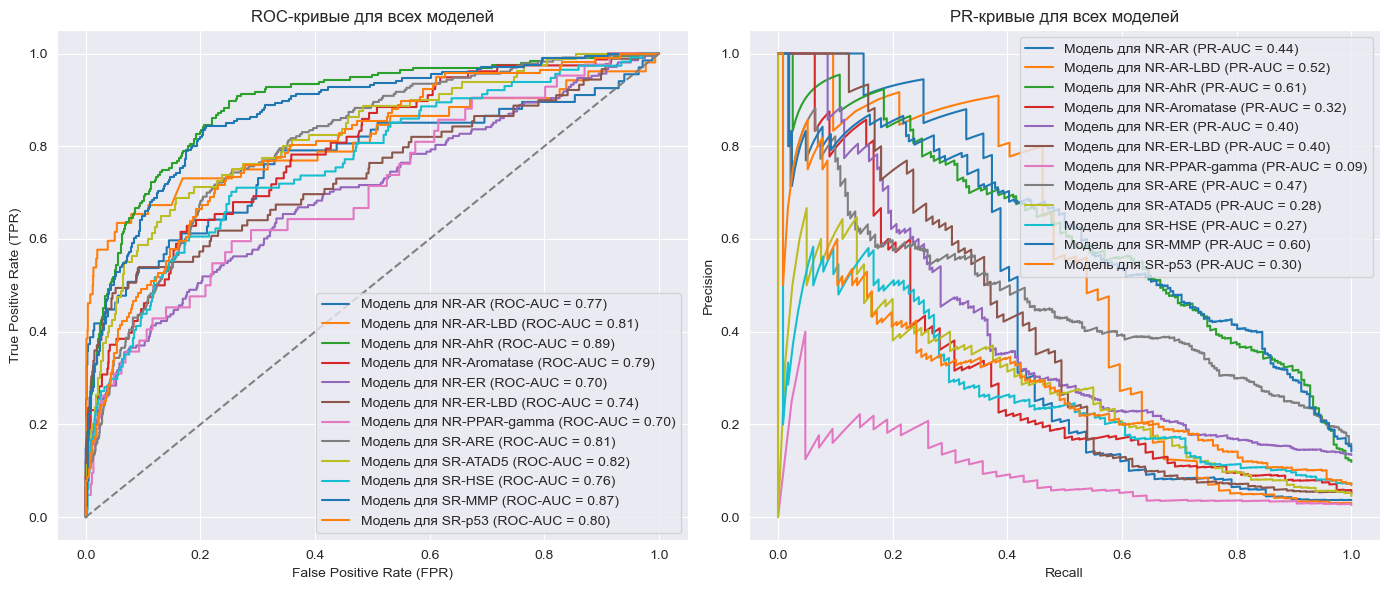

Графики сохранены в файл: comparison_curves.png


In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

names = list(metrics_for_target.keys())

# Построение графиков для всех моделей
plt.figure(figsize=(14, 6))

# ROC-кривые
plt.subplot(1, 2, 1)
for i, (y_test, y_prob) in enumerate(zip(y_test_mas, y_prob_mas)):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Модель для {names[i]} (ROC-AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-кривые для всех моделей")
plt.legend()

# PR-кривые
plt.subplot(1, 2, 2)
for i, (y_test, y_prob) in enumerate(zip(y_test_mas, y_prob_mas)):
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"Модель для {names[i]} (PR-AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-кривые для всех моделей")
plt.legend()

plt.tight_layout()
plt.savefig("comparison_curves.png", dpi=300)  # Сохранение графика
plt.show()

print("Графики сохранены в файл: comparison_curves.png")


### Графики сравнения моделей по `ROG-AUC` и `F1-score`

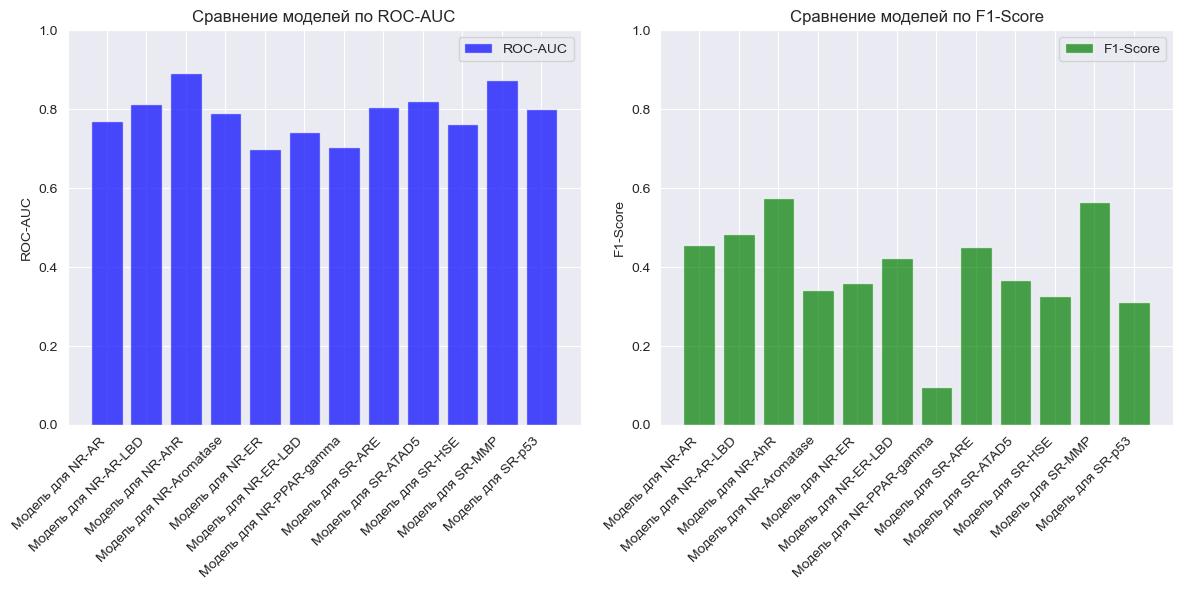

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score

# Инициализация списков для метрик
roc_auc_scores = []
f1_scores = []

# Вычисление метрик для каждой модели
for y_test, y_prob, y_pred in zip(y_test_mas, y_prob_mas, y_pred_mas):
    roc_auc = roc_auc_score(y_test, y_prob)  # ROC-AUC
    f1 = f1_score(y_test, y_pred)  # F1-Score

    roc_auc_scores.append(roc_auc)
    f1_scores.append(f1)

# Названия моделей (имена переменных)
model_names = [f"Модель для {names[i]}" for i in range(len(roc_auc_scores))]

# Построение графиков
x = range(len(model_names))  # Индексы моделей

plt.figure(figsize=(12, 6))

# ROC-AUC график
plt.subplot(1, 2, 1)
plt.bar(x, roc_auc_scores, color="blue", alpha=0.7, label="ROC-AUC")
plt.xticks(x, model_names, rotation=45, ha="right")
plt.ylim(0, 1)
plt.ylabel("ROC-AUC")
plt.title("Сравнение моделей по ROC-AUC")
plt.legend()

# F1-Score график
plt.subplot(1, 2, 2)
plt.bar(x, f1_scores, color="green", alpha=0.7, label="F1-Score")
plt.xticks(x, model_names, rotation=45, ha="right")
plt.ylim(0, 1)
plt.ylabel("F1-Score")
plt.title("Сравнение моделей по F1-Score")
plt.legend()

plt.tight_layout()
plt.savefig("model_comparison_roc_auc_f1.png", dpi=300)  # Сохранение графика
plt.show()


### Графики `SNAP`-важности признаков для каждой из моделей

В связи с тем, что многие признаки имеют нулевую важность, то отображать их на графиках смысла не имеет, поэтому отбросим их

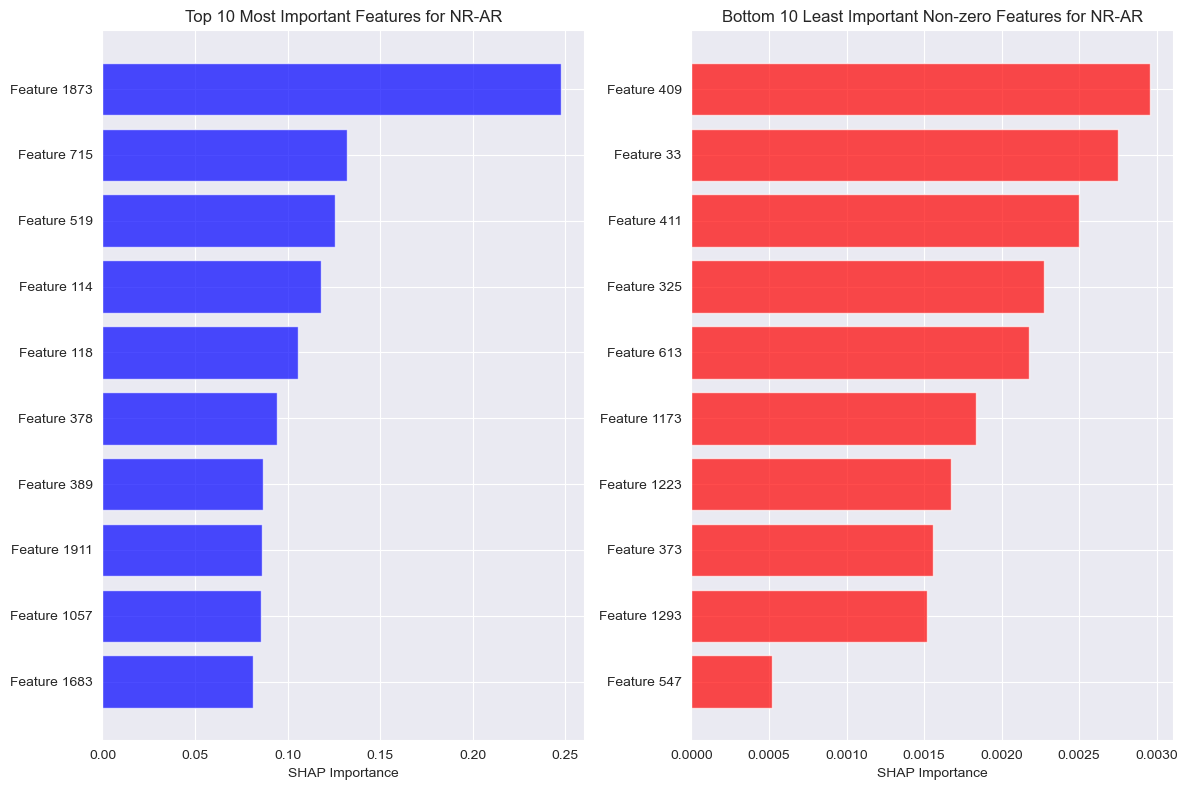

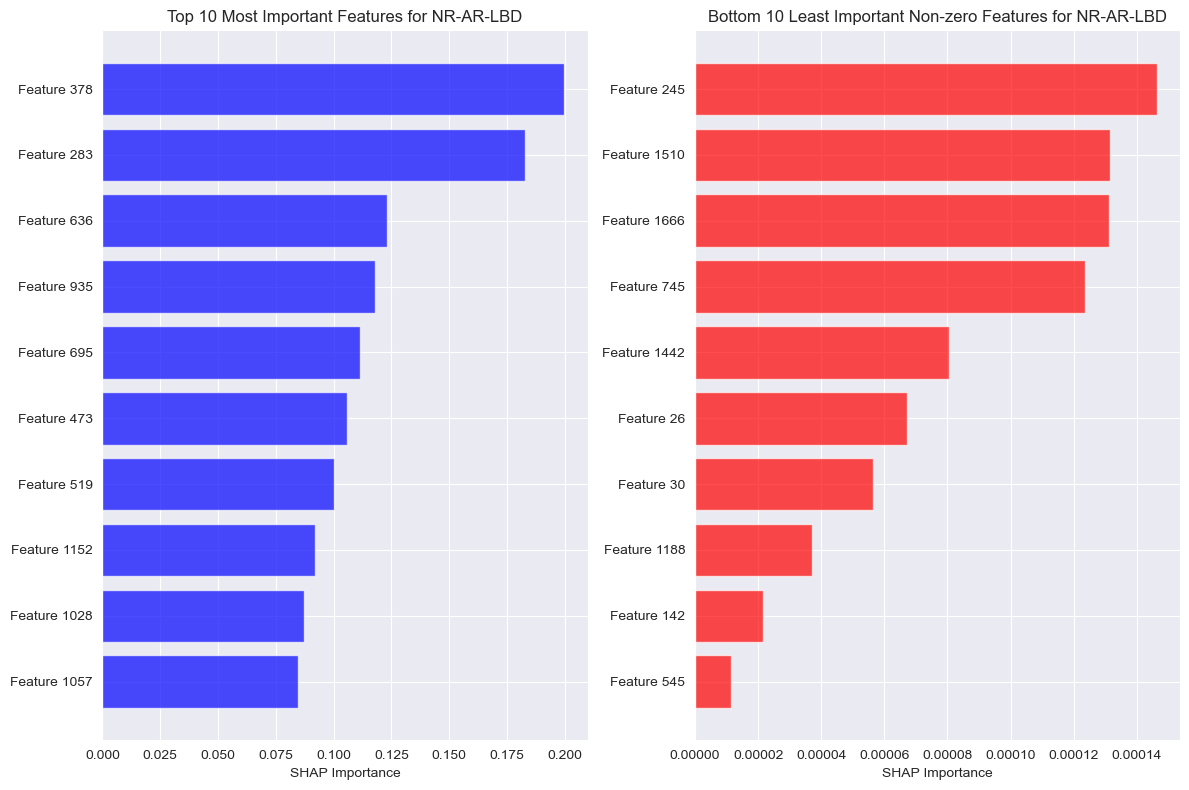

100%|===================| 1630/1638 [00:53<00:00]        

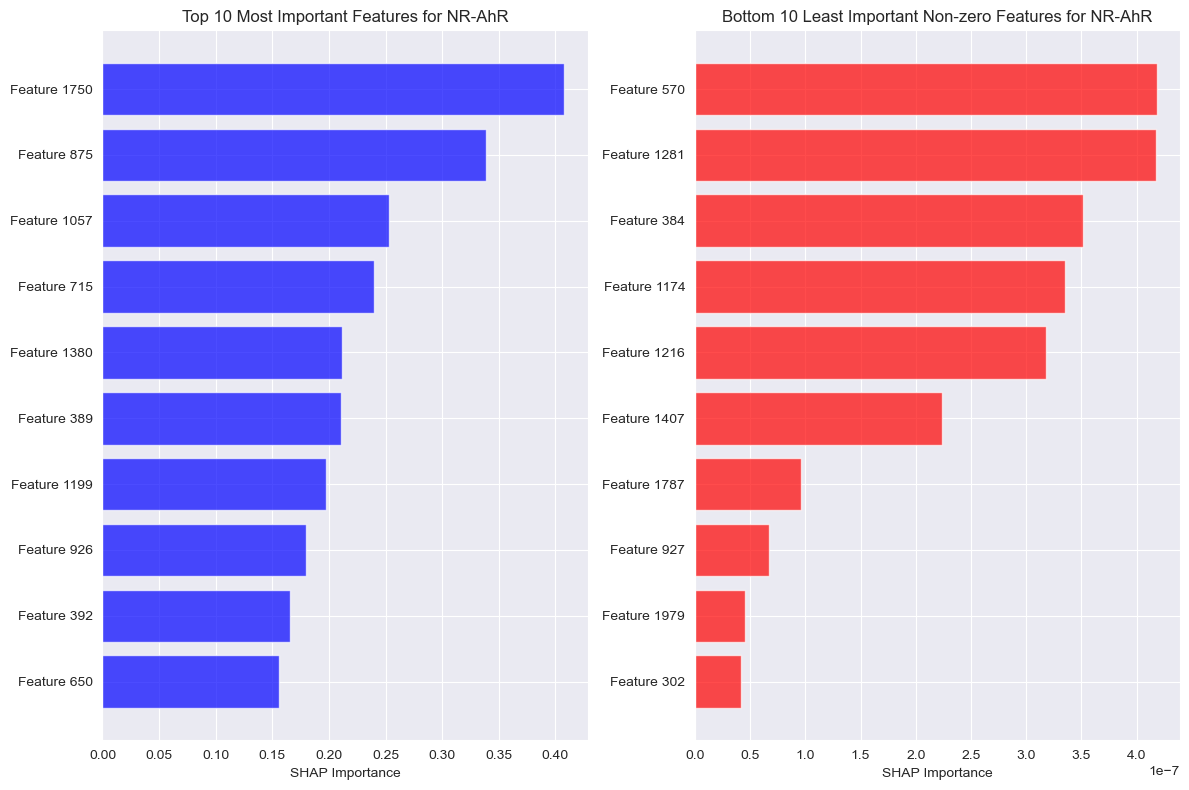

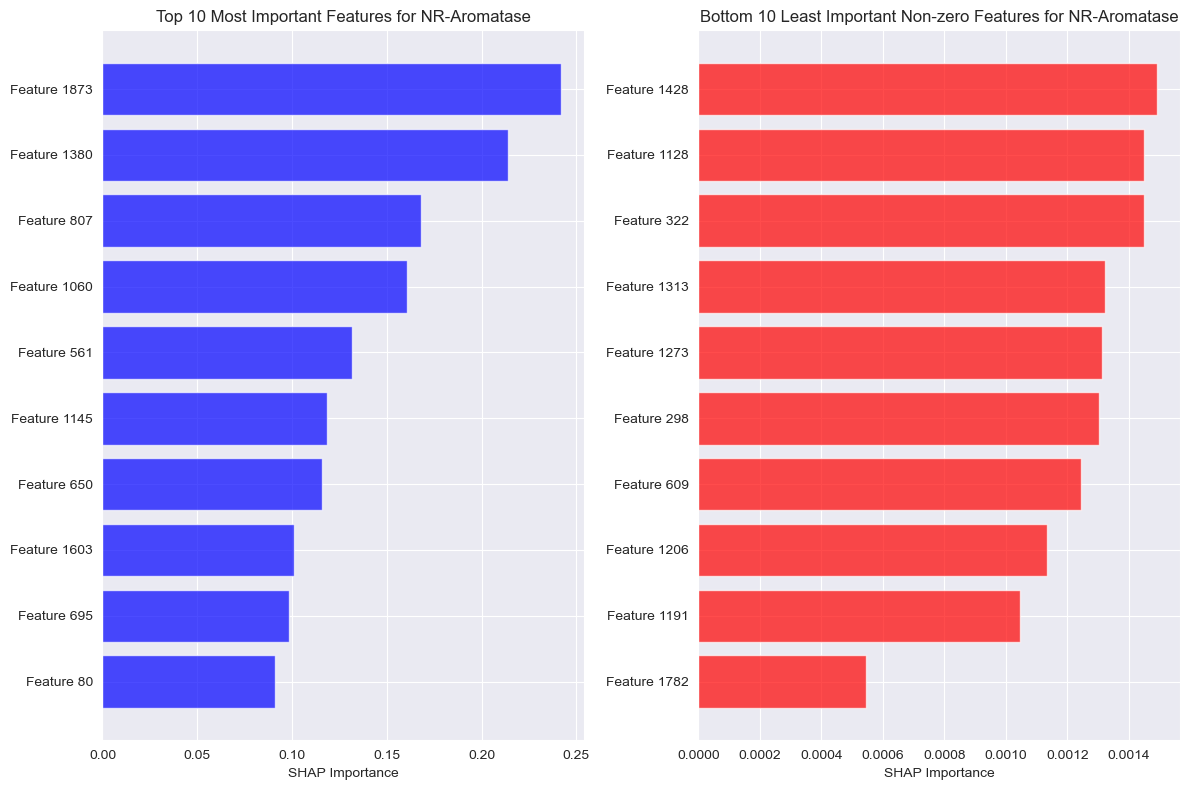

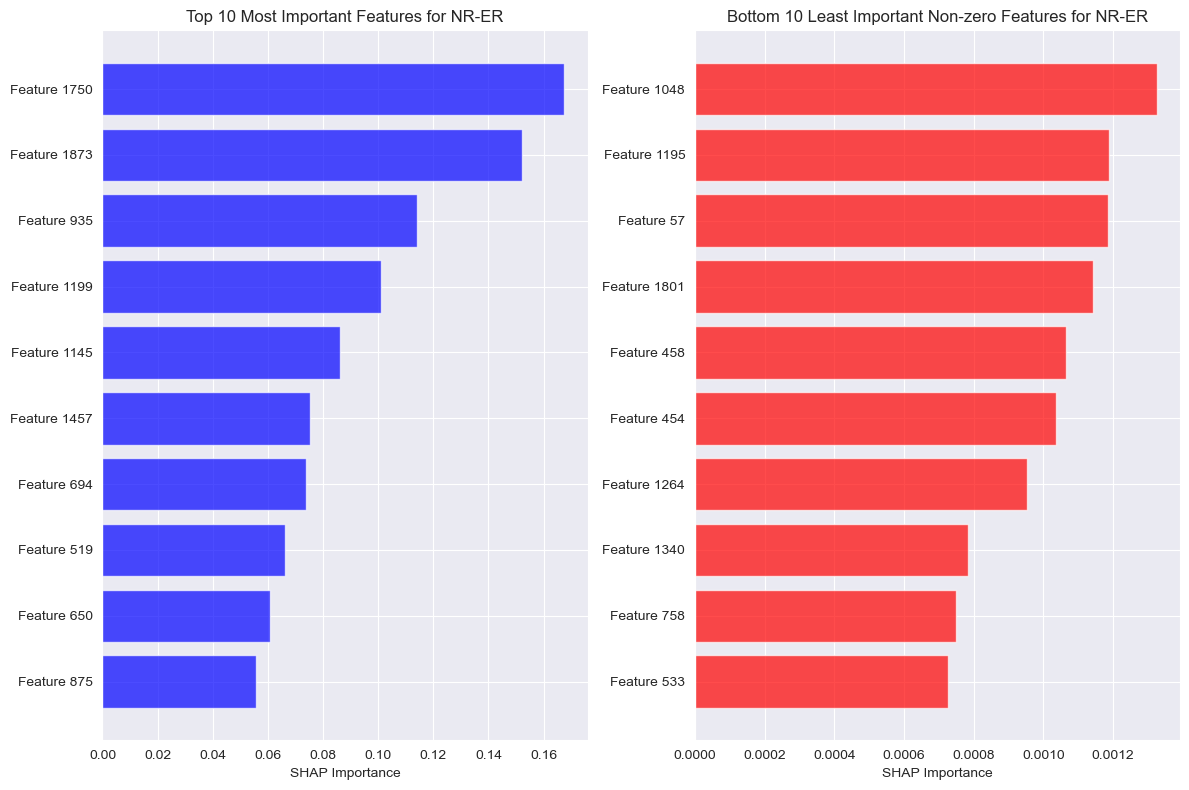

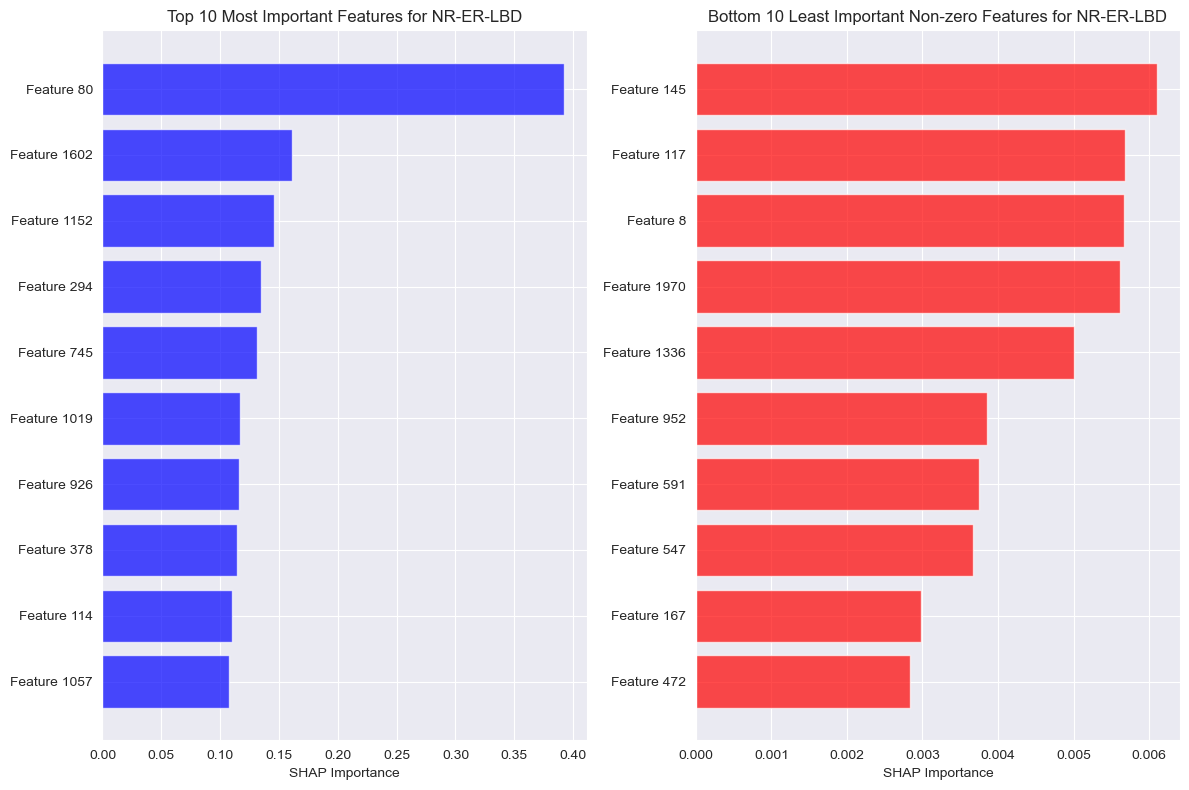

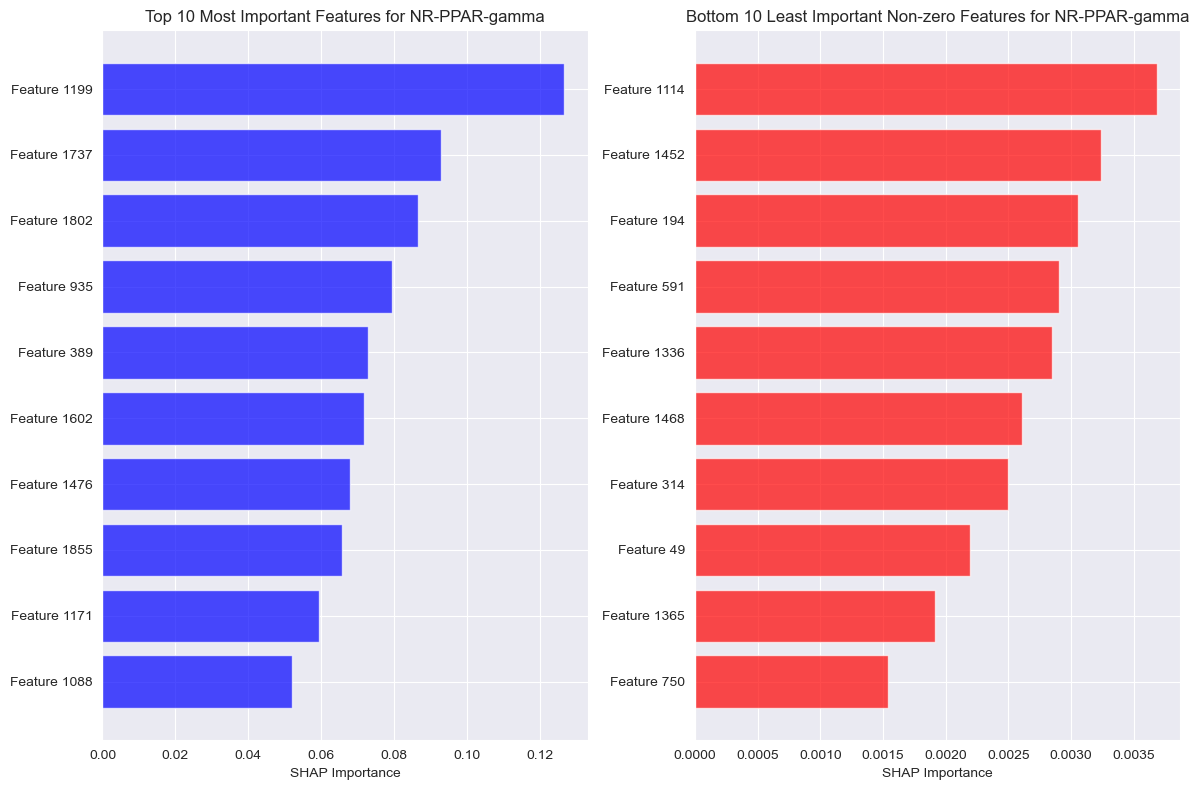

 97%|=================== | 1419/1458 [00:30<00:00]       

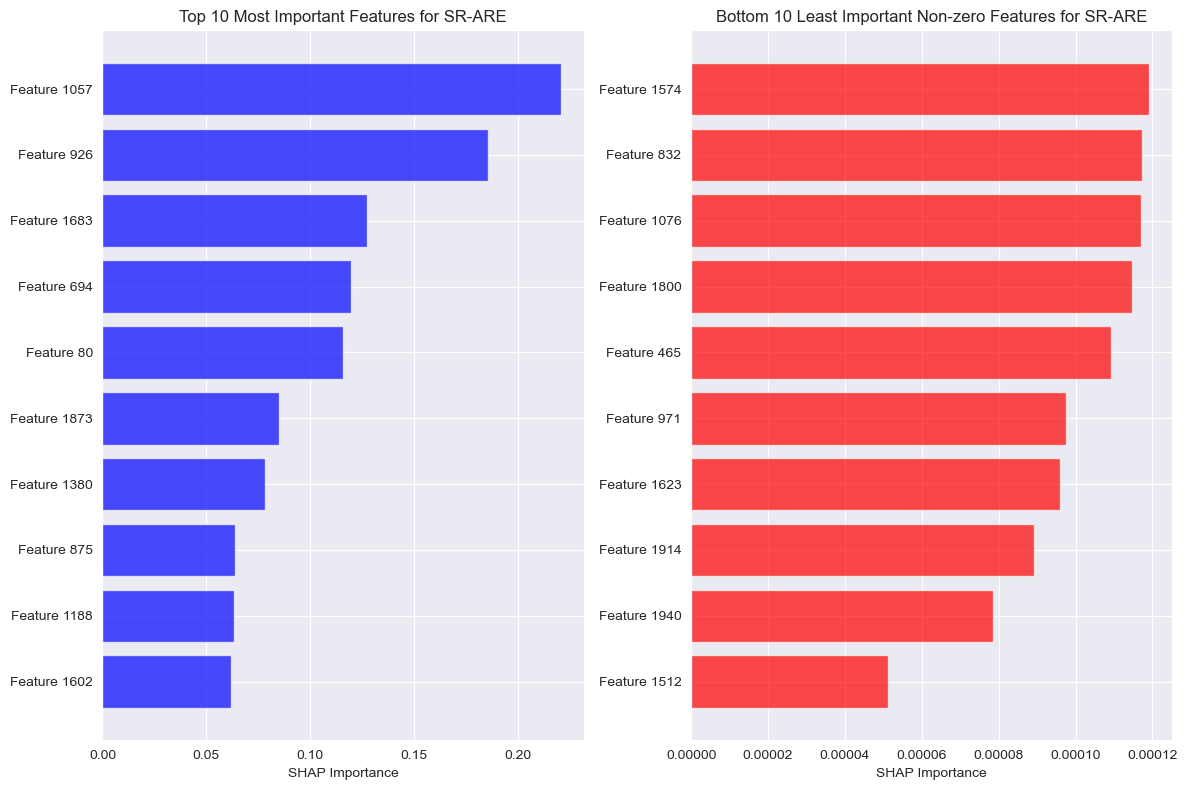

 95%|=================== | 1688/1768 [00:16<00:00]       

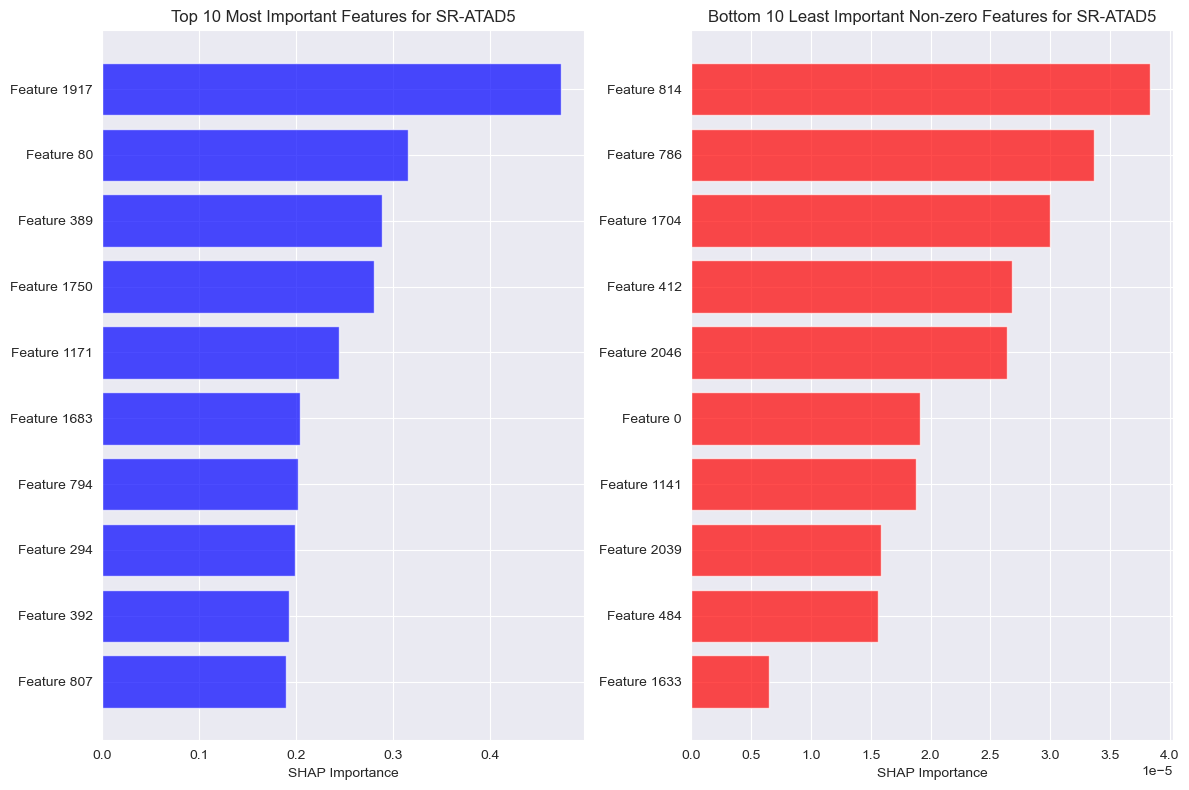

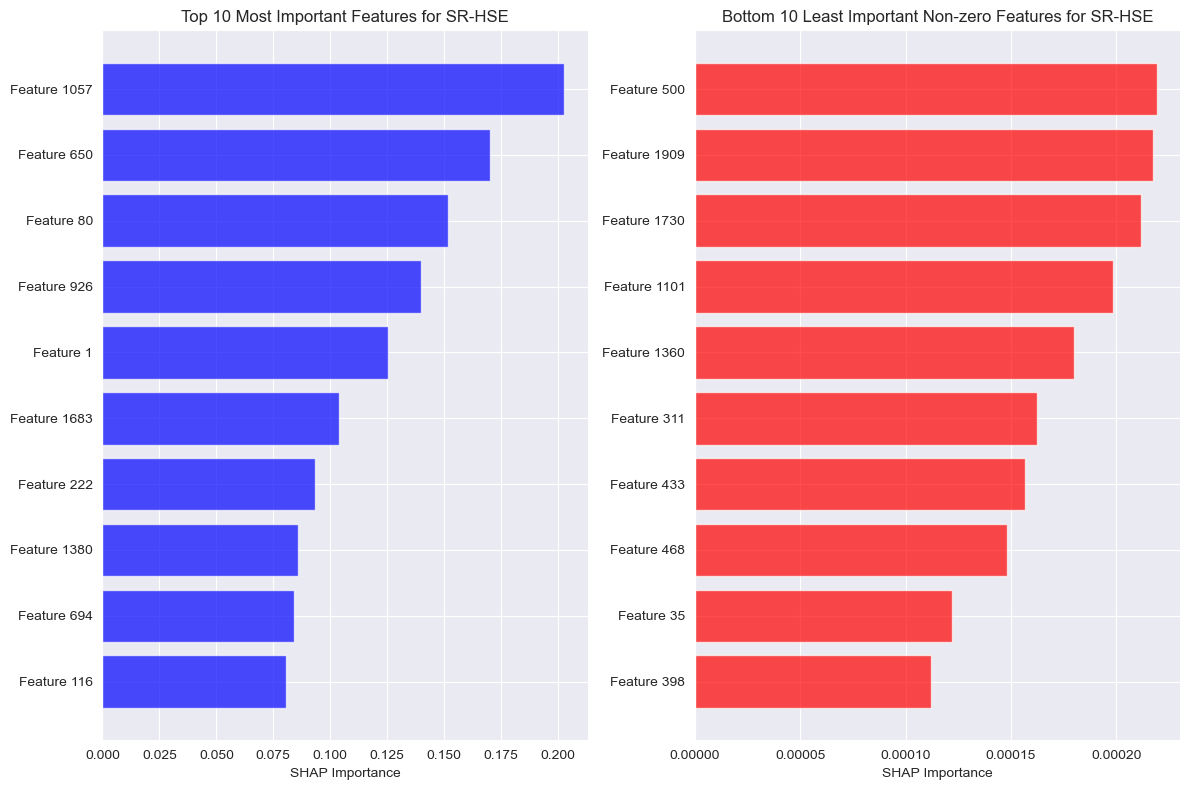

 99%|===================| 1444/1453 [00:31<00:00]        

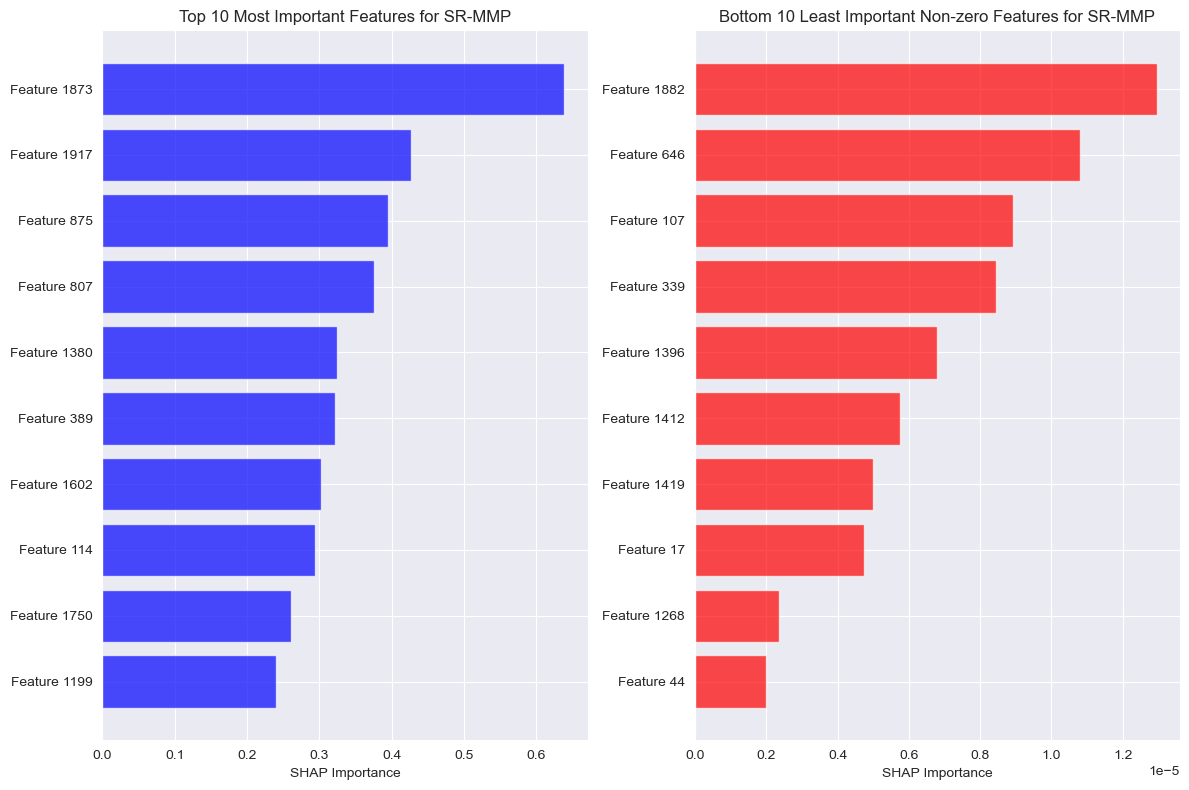

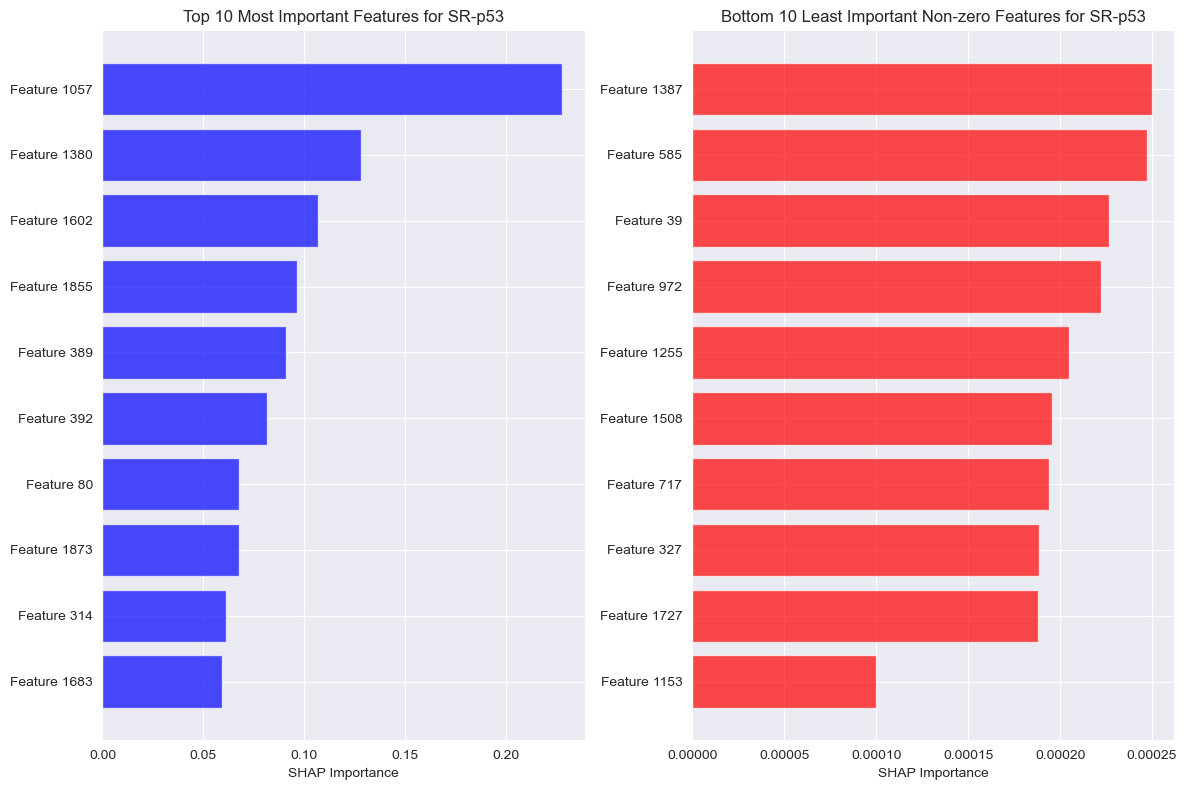

In [91]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

for target, params in metrics_for_target.items():
    model = XGBClassifier(**(params[0]), tree_method='hist', device='cuda', random_state=42)
    df_cleaned = df.dropna(subset=[target, "morgan_fp"])
    X = np.array(df_cleaned["morgan_fp"].values.tolist())
    y = df_cleaned[target].astype(int).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

    model.fit(X_train, y_train)

    # SHAP анализ
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    # Суммируем абсолютные значения SHAP для каждого признака
    shap_importance = np.abs(shap_values.values).mean(axis=0)

    # Создаём DataFrame с названиями признаков и их важностью
    feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": shap_importance
    }).sort_values(by="Importance", ascending=False)

    # Отображаем топ-10 признаков
    top_10 = importance_df.head(10)

    # Отображаем 10 наименее значимых ненулевых признаков
    bottom_10 = importance_df[importance_df["Importance"] > 0].tail(10)

    # Построение графиков
    plt.figure(figsize=(12, 8))

    # График для топ-10 признаков
    plt.subplot(1, 2, 1)
    plt.barh(top_10["Feature"], top_10["Importance"], color="blue", alpha=0.7)
    plt.xlabel("SHAP Importance")
    plt.title(f"Top 10 Most Important Features for {target}")
    plt.gca().invert_yaxis()

    # График для наименее важных ненулевых признаков
    plt.subplot(1, 2, 2)
    plt.barh(bottom_10["Feature"], bottom_10["Importance"], color="red", alpha=0.7)
    plt.xlabel("SHAP Importance")
    plt.title(f"Bottom 10 Least Important Non-zero Features for {target}")
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()


### Графики `feature_importance`

Как и в предыдущем пункте, фичи с нулевой важностью отбрасываем


Анализ признаков для NR-AR:


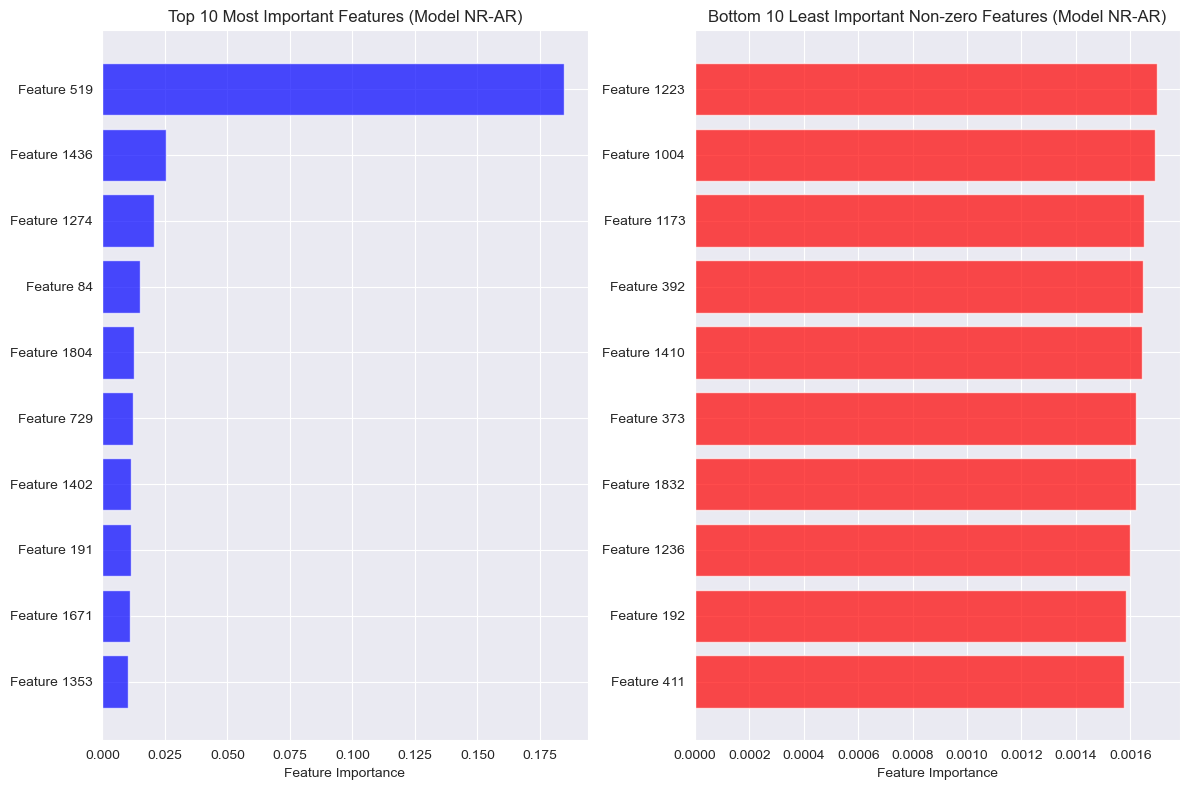


Анализ признаков для NR-AR-LBD:


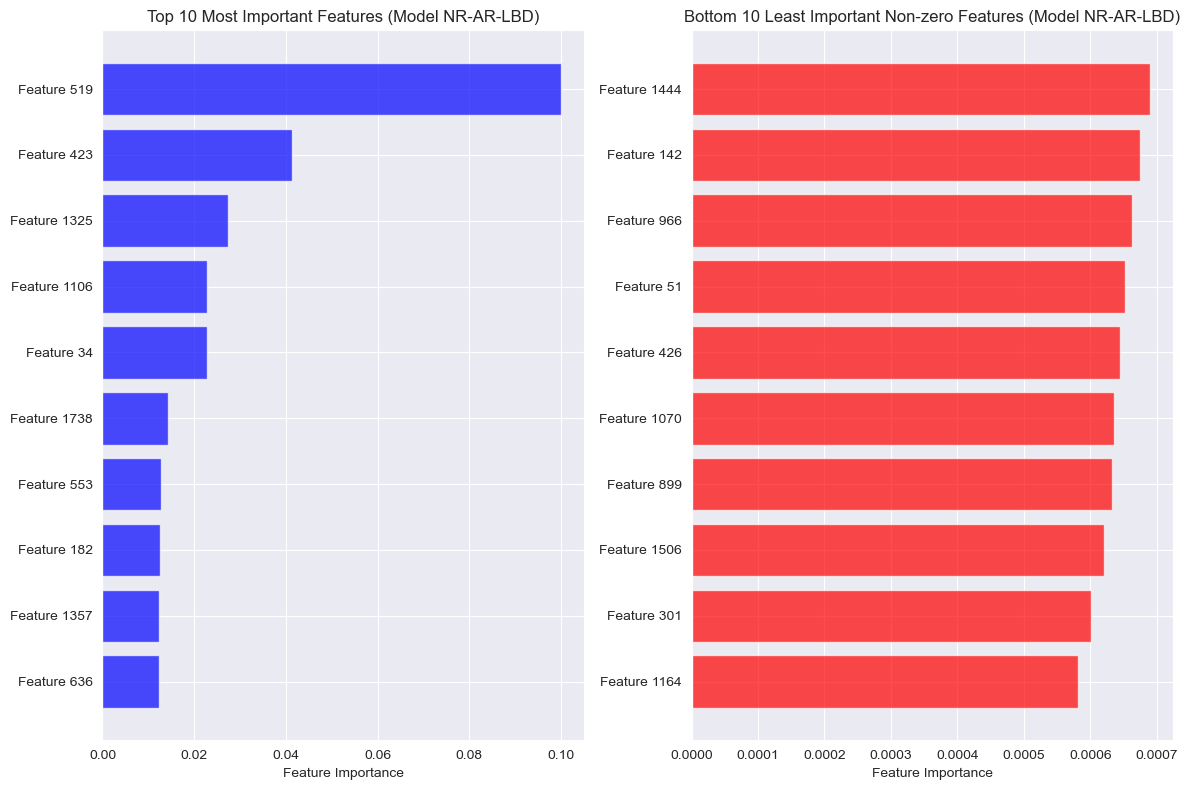


Анализ признаков для NR-AhR:


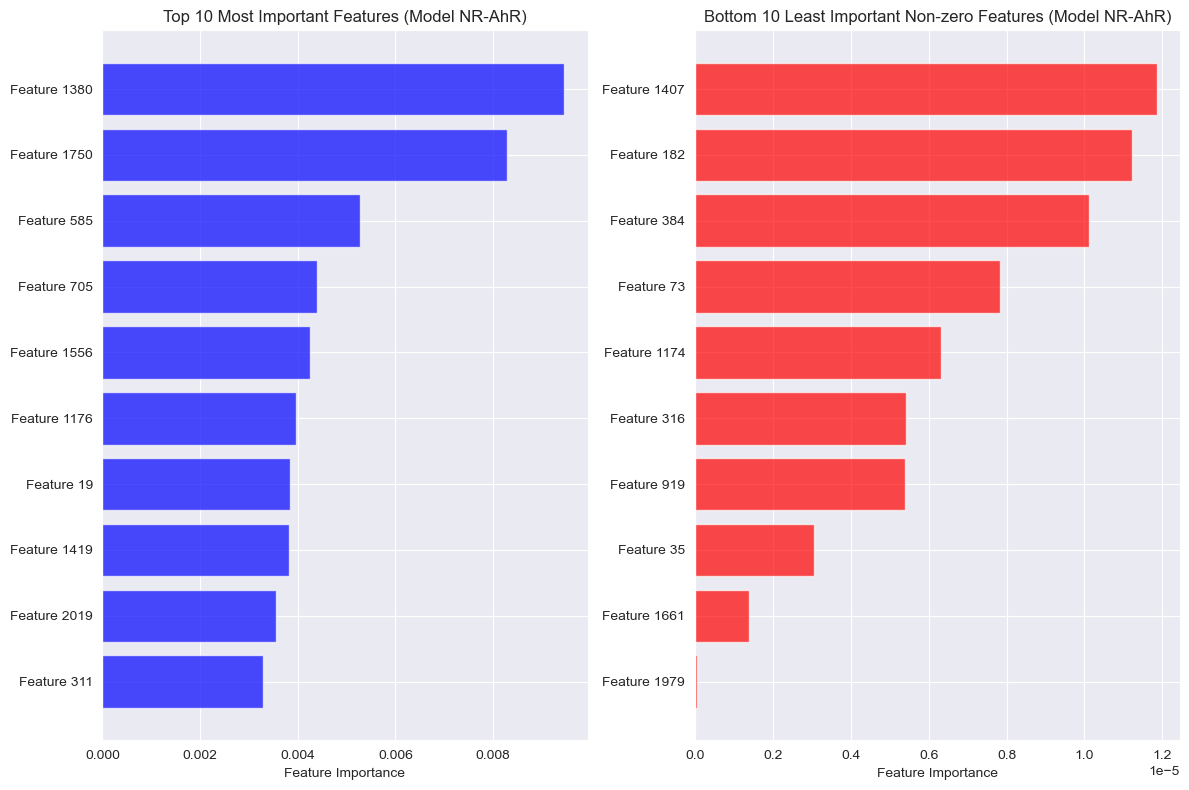


Анализ признаков для NR-Aromatase:


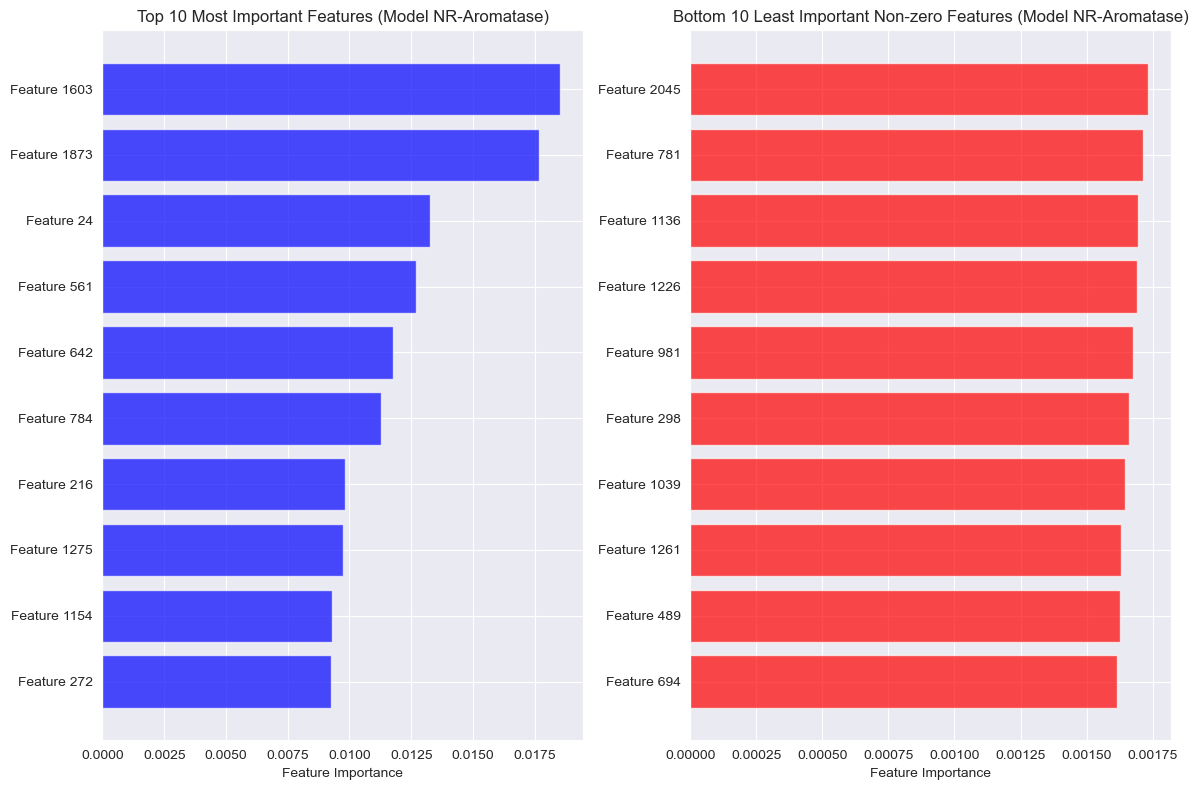


Анализ признаков для NR-ER:


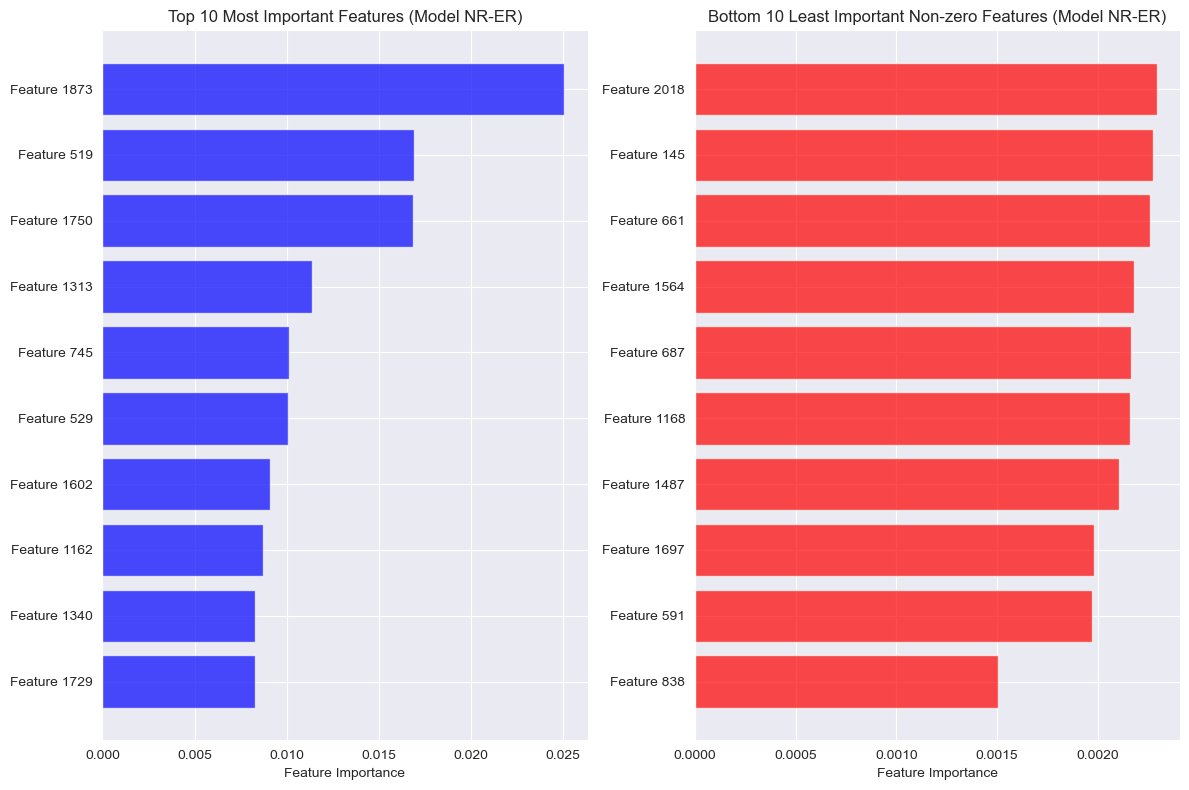


Анализ признаков для NR-ER-LBD:


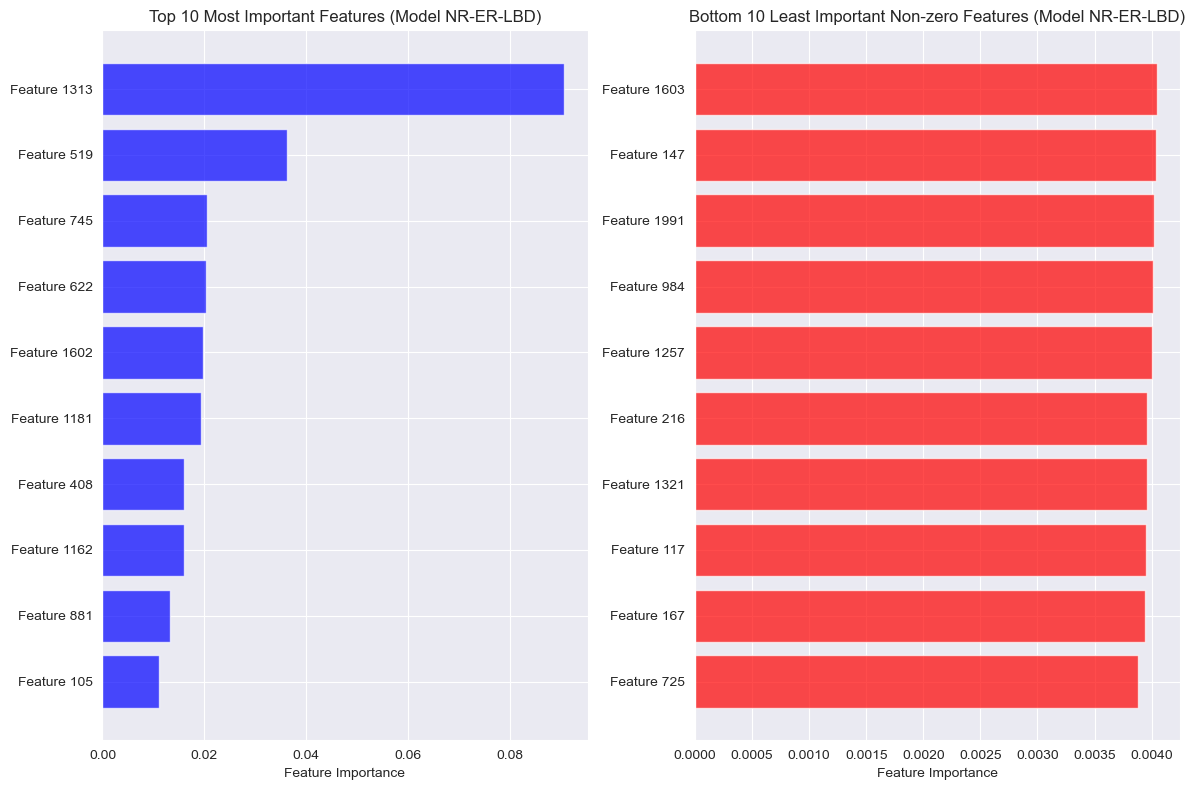


Анализ признаков для NR-PPAR-gamma:


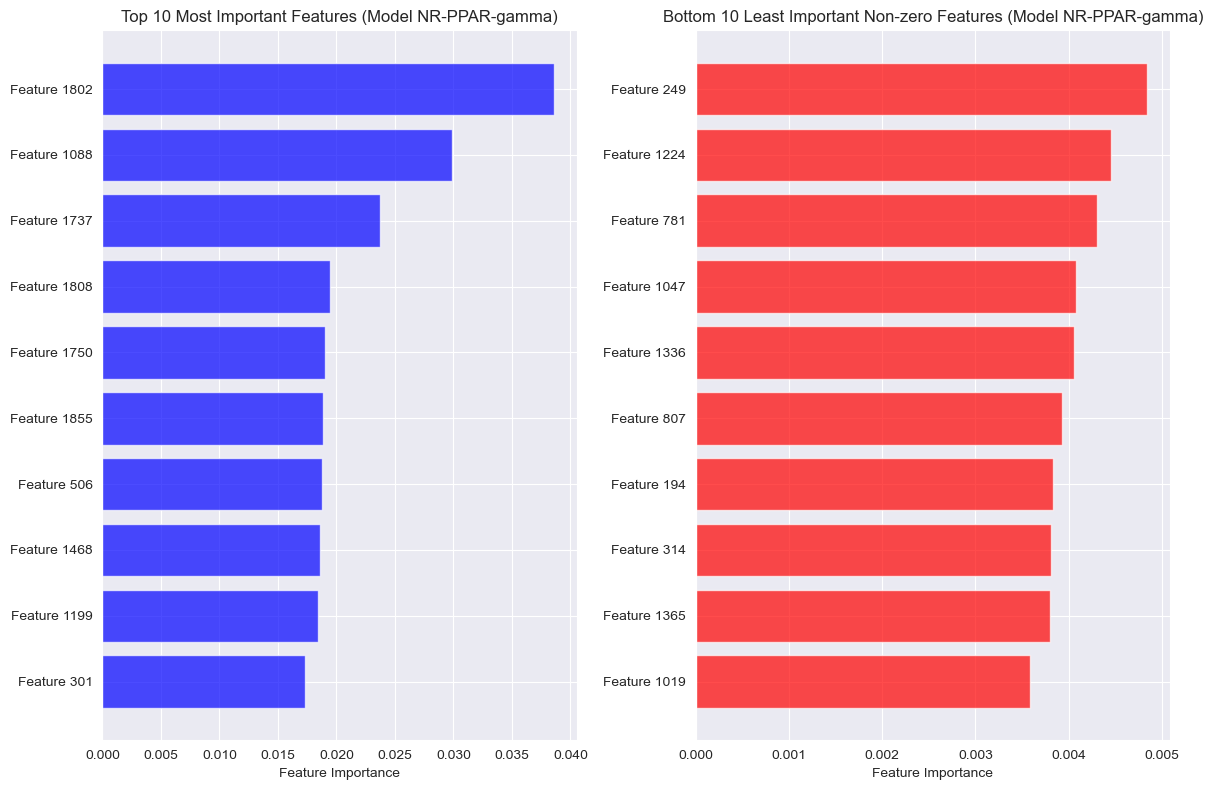


Анализ признаков для SR-ARE:


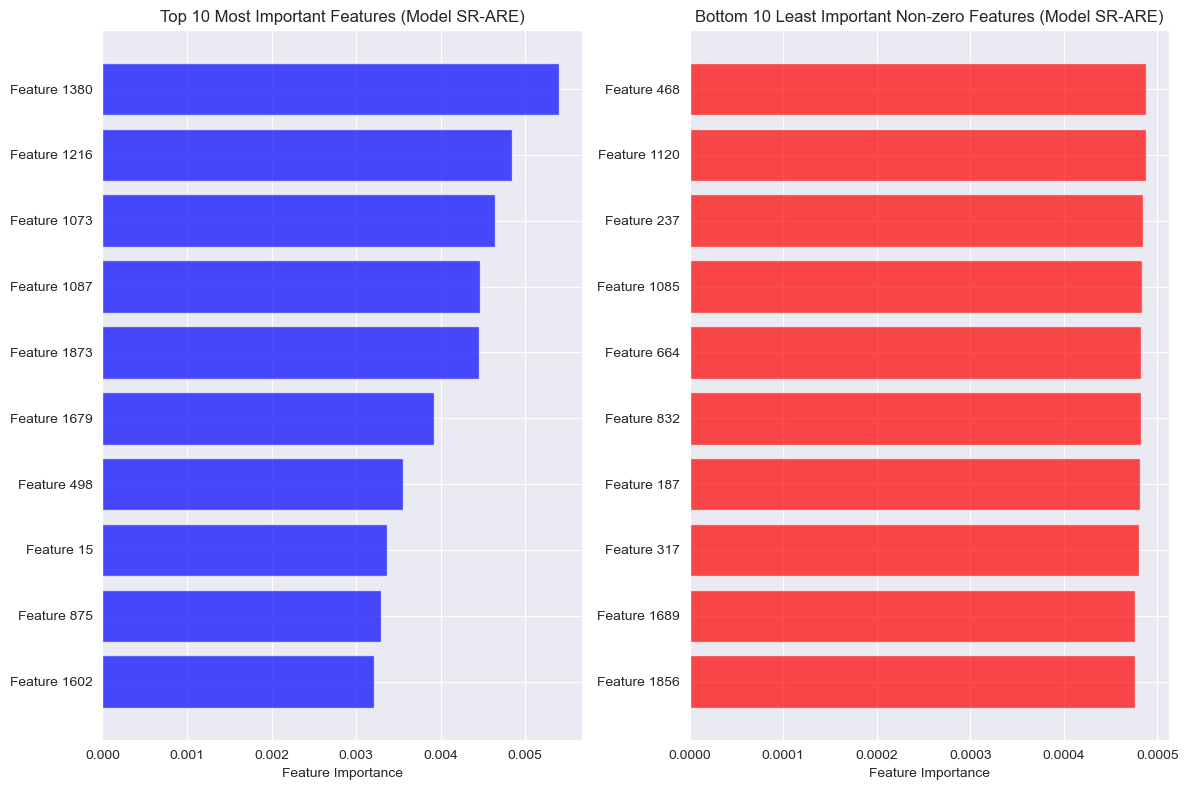


Анализ признаков для SR-ATAD5:


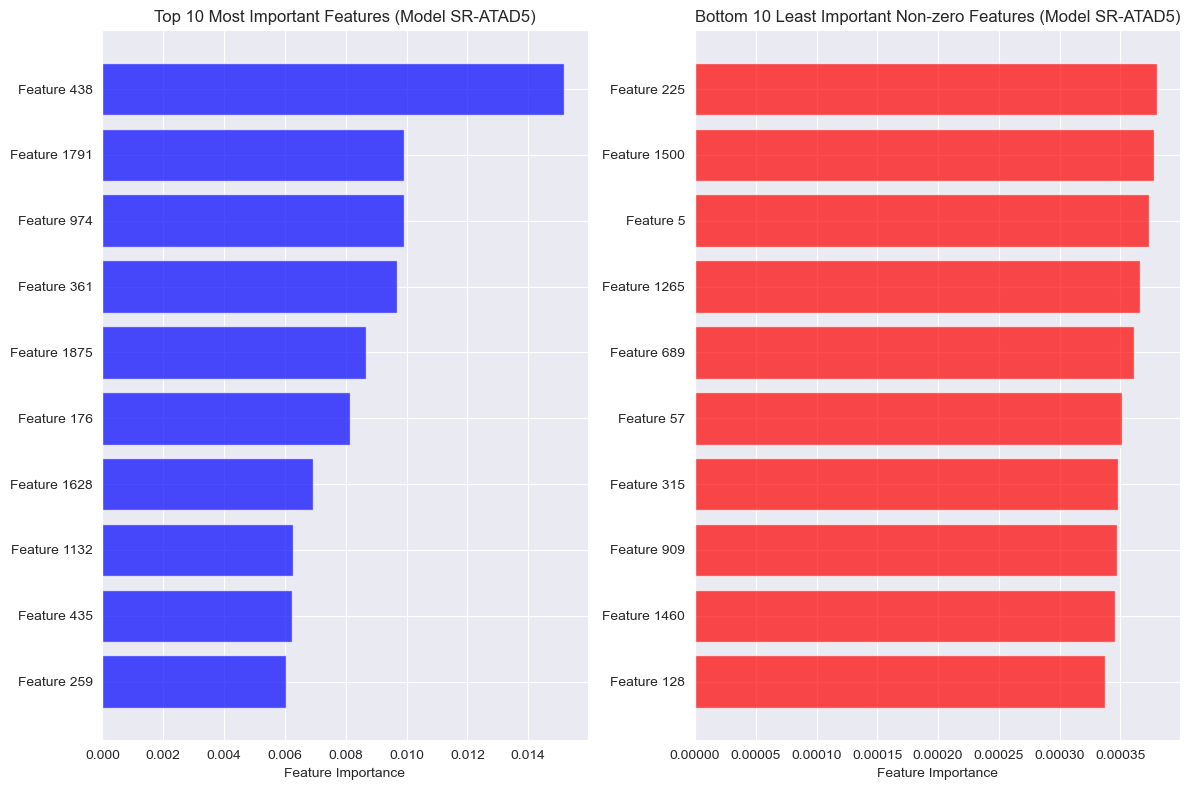


Анализ признаков для SR-HSE:


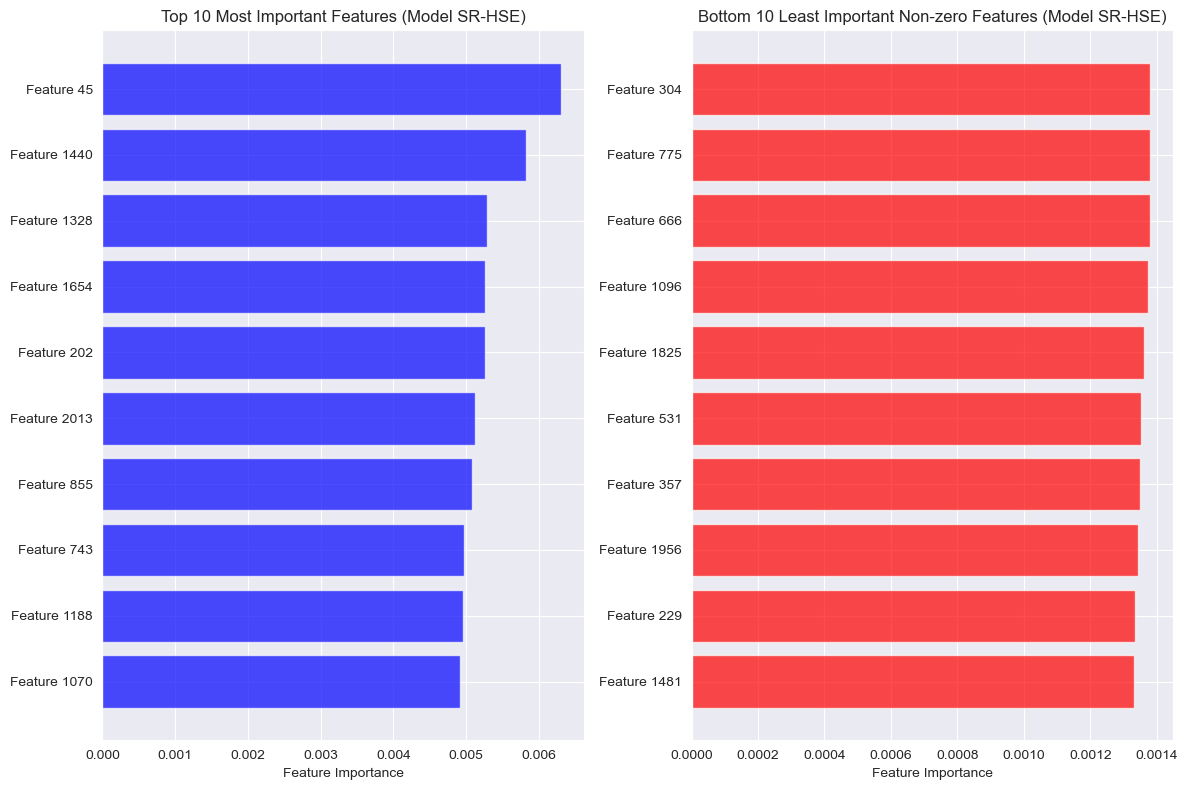


Анализ признаков для SR-MMP:


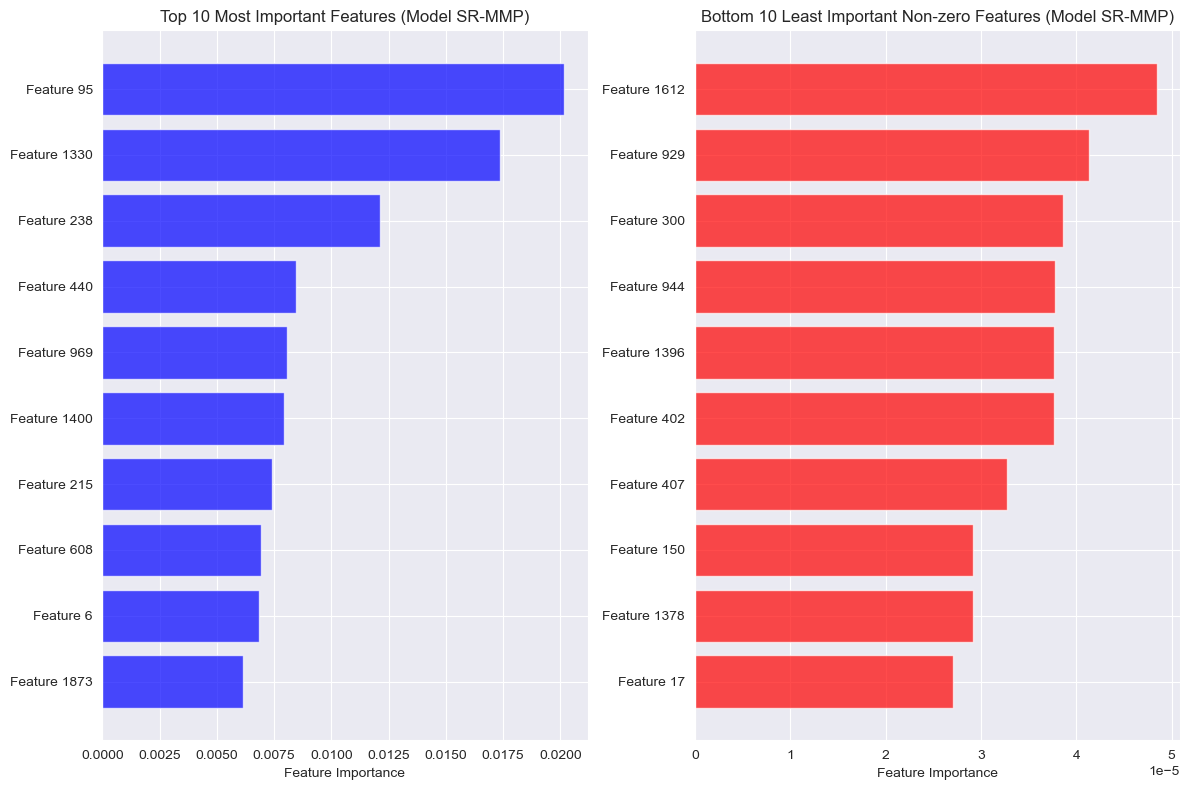


Анализ признаков для SR-p53:


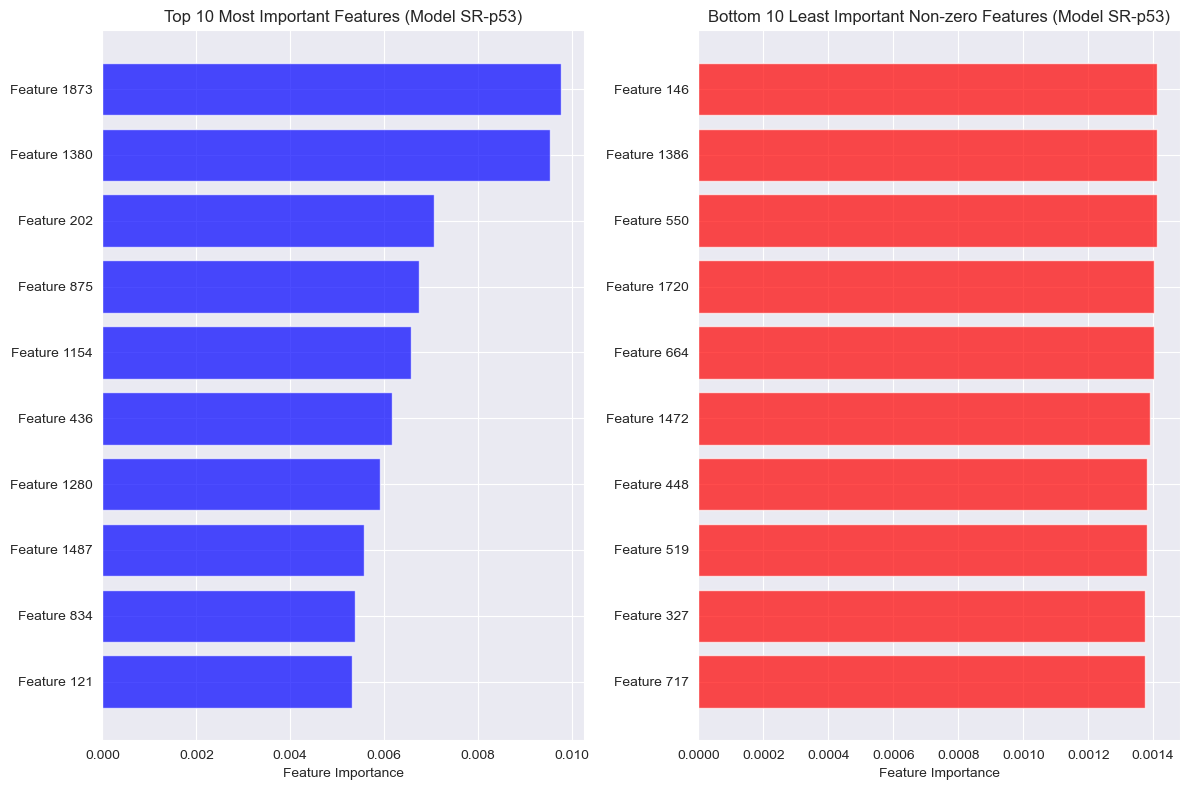

In [92]:
for i, (importance, feature_names) in enumerate(zip(importance_mas, feature_names_mas)):
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)

    top_10 = importance_df.head(10)

    bottom_10 = importance_df[importance_df["Importance"] > 0].tail(10)

    print(f"\nАнализ признаков для {names[i]}:")

    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.barh(top_10["Feature"], top_10["Importance"], color="blue", alpha=0.7)
    plt.xlabel("Feature Importance")
    plt.title(f"Top 10 Most Important Features (Model {names[i]})")
    plt.gca().invert_yaxis()

    plt.subplot(1, 2, 2)
    plt.barh(bottom_10["Feature"], bottom_10["Importance"], color="red", alpha=0.7)
    plt.xlabel("Feature Importance")
    plt.title(f"Bottom 10 Least Important Non-zero Features (Model {names[i]})")
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

## Анализ построенных моделей XGBoost для различных целевых переменных

На основании графиков ROC-AUC, PR-AUC и F1-score можно сделать следующие выводы:

---


### 1. **Общая характеристика моделей**
- Каждая модель XGBoost была оптимизирована для своей целевой переменной с использованием подбора гиперпараметров.
- ROC-AUC показывает, насколько хорошо модель различает классы. Высокие значения ROC-AUC указывают на хорошую способность модели предсказывать истинно положительные и истинно отрицательные классы.
- PR-AUC показывает, как модель работает с несбалансированными данными, концентрируясь на предсказании положительных классов.
- F1-score балансирует точность (precision) и полноту (recall), что особенно важно для задач с несбалансированными классами.

---

### 2. **Наиболее успешные модели**

#### **По ROC-AUC:**
- **Модель для SR-MMP**:
  - ROC-AUC = 0.87, что является наивысшим значением среди всех моделей.
  - Это указывает на высокую способность различать классы.
- **Модель для NR-AhR**:
  - ROC-AUC = 0.89, также демонстрирует отличный результат.
  - Это делает её подходящей для задач, требующих точных классификаций.

#### **По PR-AUC:**
- **Модель для NR-AhR**:
  - PR-AUC = 0.61, лучший результат для задач, где важно учитывать положительные классы.
- **Модель для SR-MMP**:
  - PR-AUC = 0.60, также показывает высокую точность для положительных классов.

#### **По F1-score:**
- **Модель для SR-MMP**:
  - Высокий F1-score, что делает её сбалансированной моделью для точности и полноты.
- **Модель для NR-AR-LBD**:
  - Также демонстрирует достойные результаты.

---

### 3. **Наименее успешные модели**

#### **По ROC-AUC:**
- **Модель для NR-ER**:
  - ROC-AUC = 0.70, что ниже остальных моделей.
  - Это указывает на недостаточную способность различать классы.

#### **По PR-AUC:**
- **Модель для NR-PPAR-gamma**:
  - PR-AUC = 0.09, что значительно ниже остальных моделей.
  - Это делает её непригодной для задач с несбалансированными данными.

#### **По F1-score:**
- **Модель для NR-PPAR-gamma**:
  - Низкий F1-score указывает на слабую сбалансированность между точностью и полнотой.

---



### 4. **Причины низких значений F1-score**


#### Основные предположения:
1. **Дисбаланс классов**
   - Один класс доминирует над другим, что приводит к низкому значению полноты (recall).
   - PR-AUC показывает лучшую работу модели на положительных классах, что подтверждает дисбаланс.

2. **Шумные или слабокоррелированные признаки**
   - Большое количество признаков с низкой или нулевой важностью может "размывать" модель.
   - Это снижает её способность выделять значимые паттерны.

3. **Недостаток данных**
   - Небольшой объём данных усложняет обучение модели.

### 5. **Заключение**
Модели XGBoost продемонстрировали хорошую производительность для большинства целевых переменных. Особенно выделяются **NR-AhR** и **SR-MMP**, которые показывают наилучший баланс между всеми метриками. Модели для **NR-ER** и **NR-PPAR-gamma** требуют доработки или анализа данных, чтобы повысить их эффективность.